# Earnings Manipulation

## By Kumar Rahul

The analysis is on company financial manipulations and devise algorithm to identify a manipulater from a non manipulater based on the financial ratios reported by the companies. There are a total of 1239 observations in the data set. Out of these 1239 observations, there are 1200 non manipulaters and 39 manipulaters.

> 1. [Look](http://topepo.github.io/caret/train-models-by-tag.html) for different types of model which can be built using R. Also has a guideline for fine tuning paramters
> 2. Refer [link](http://stats.stackexchange.com/questions/163799/training-a-random-forest-in-r-with-a-maximum-false-positive-rate) to know random forest and [Refer](http://stackoverflow.com/questions/18541923/what-is-out-of-bag-error-in-random-forests) to know about OOB error
> 3. [Demonstration](https://rpubs.com/chengjiun/52658) of some of the bagging and boosting algorithm
> 4. [Understand](https://www.r-bloggers.com/improve-predictive-performance-in-r-with-bagging/) the logic for bagging in logistic regression
> 5. [Interpret](http://stackoverflow.com/questions/14996619/random-forest-output-interpretation) the tree structure generated out of random forest model

***



Not all the packages are available for installation through anaconda r-essentials. To install the packages which are not available through anaconda framework, use the below code chunk:

In [1]:
#install.packages("inTrees", "/Users/Rahul/anaconda3/lib/R/library")
#install.packages("DMwR", "/Users/Rahul/anaconda3/lib/R/library")
#install.packages("UBL", "/Users/Rahul/anaconda3/lib/R/library")
#install.packages("adabag", "/Users/Rahul/anaconda3/lib/R/library")
#install.packages("tictoc", "/Users/Rahul/anaconda3/lib/R/library")
#install.packages("doMC", "/Users/Rahul/anaconda3/lib/R/library")

In [2]:
library(caret)          #for split and model accuracy
library(DMwR)           #for SMOTE Sampling
library(randomForest)
library(ROCR)           #for ROC Plot
library(e1071)
library(xgboost)        #to implement xgbTree
#library(rattle)        #print the business rules for the model
library(inTrees)        #to extract the business rules from rf model
library(UBL)
library(tictoc)         #to record the time elapsed
library(parallel)
library(doParallel)
library(doMC)
setwd("/Users/Rahul/Documents/Rahul Office/IIMB/Work @ IIMB/Company Fraud")

Loading required package: lattice
Loading required package: ggplot2
Loading required package: grid
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: MBA
Loading required package: gstat
Loading required package: automap
Loading required package: sp
Loading required package: foreach
Loading required package: iterators



## Preparing data

#### Read data from a specified location


In [3]:
raw_data <- read.csv("/Users/Rahul/Documents/Rahul Office/IIMB/Work @ IIMB/Company Fraud/fraud_data.csv",
                     head=TRUE,na.strings=c("", " ", "NA"), sep=",")

filter_data <- raw_data[,-c(1)]


#### Define an 70%/30% train/test split of the dataset


In [4]:
set.seed(4121)
trainIndex <- createDataPartition(filter_data$Manipulater, p = 0.70, list=FALSE)
train_df <- filter_data[ trainIndex,]
test_df <- filter_data[-trainIndex,]


#### Prepare and run numerical summaries


In [5]:
summary(train_df) #summary of the data
train_df <- na.omit(train_df) # listwise deletion of missing
test_df <- na.omit(test_df) # listwise deletion of missing

      DSRI              GMI                AQI                SGI          
 Min.   : 0.0000   Min.   :-20.8118   Min.   :-21.7338   Min.   : 0.06454  
 1st Qu.: 0.8876   1st Qu.:  0.9253   1st Qu.:  0.7856   1st Qu.: 0.97341  
 Median : 1.0200   Median :  1.0000   Median :  1.0079   Median : 1.09614  
 Mean   : 1.1387   Mean   :  0.9778   Mean   :  1.0763   Mean   : 1.13740  
 3rd Qu.: 1.1872   3rd Qu.:  1.0507   3rd Qu.:  1.2110   3rd Qu.: 1.20608  
 Max.   :15.3435   Max.   : 46.4667   Max.   : 52.8867   Max.   :13.06465  
      DEPI              SGAI              ACCR               LEVI        
 Min.   :0.06882   Min.   : 0.0000   Min.   :-0.68226   Min.   : 0.0000  
 1st Qu.:0.93554   1st Qu.: 0.9008   1st Qu.:-0.07631   1st Qu.: 0.9232  
 Median :1.00000   Median : 1.0002   Median :-0.03004   Median : 1.0133  
 Mean   :1.02915   Mean   : 1.1073   Mean   :-0.03045   Mean   : 1.0574  
 3rd Qu.:1.07637   3rd Qu.: 1.1290   3rd Qu.: 0.02016   3rd Qu.: 1.1154  
 Max.   :5.39387   Max. 


#### Train and test dataset with needed variables


In [6]:
model_df <- as.data.frame(filter_data[,c(#"DSRI",
                                       #"GMI",
                                       "AQI",
                                       #"SGI",
                                       "DEPI",
                                       "SGAI",
                                       "ACCR",
                                       "LEVI",
                                       "Manipulater"
)])

model_train_df <- as.data.frame(train_df[,c(#"DSRI",
                                          #"GMI",
                                          "AQI",
                                          #"SGI",
                                          "DEPI",
                                          "SGAI",
                                          "ACCR",
                                          "LEVI",
                                          "Manipulater"
)])

model_test_df <- as.data.frame(test_df[,c(#"DSRI",
                                        #"GMI",
                                        "AQI",
                                        #"SGI",
                                        "DEPI",
                                        "SGAI",
                                        "ACCR",
                                        "LEVI",
                                        "Manipulater"
)])



#### Corelation amongst variable

The below chunk of code will show the co-relation if any between the numerical variables. The function **highlyCorelated()** shows the variables which are corelated with an absolute corelation of more than 0.6. In this case there are no variables which are highly corelated.


In [7]:
correlation_matrix <- cor(model_df[,c(1:5)])
print(correlation_matrix)
# find attributes that are highly corrected (ideally >0.7)
highly_correlated <- findCorrelation(correlation_matrix, cutoff = 0.6, names = TRUE)
print(highly_correlated)

              AQI        DEPI         SGAI        ACCR        LEVI
AQI   1.000000000 -0.02124161  0.003712316 -0.04542383  0.07027302
DEPI -0.021241615  1.00000000 -0.067247329 -0.01661336 -0.01271157
SGAI  0.003712316 -0.06724733  1.000000000 -0.09066795  0.02174950
ACCR -0.045423827 -0.01661336 -0.090667950  1.00000000 -0.01163113
LEVI  0.070273016 -0.01271157  0.021749500 -0.01163113  1.00000000
character(0)



## Caret Package

**caret** is a useful and a robust package which helps to set a generic framework to implement any kind of model in R. Some of the algorithm's which can be implemented using caret package are:


In [8]:
names(getModelInfo())

#getModelInfo()$glm

[1] "ada"                 "AdaBag"              "AdaBoost.M1"        
  [4] "adaboost"            "amdai"               "ANFIS"              
  [7] "avNNet"              "awnb"                "awtan"              
 [10] "bag"                 "bagEarth"            "bagEarthGCV"        
 [13] "bagFDA"              "bagFDAGCV"           "bam"                
 [16] "bartMachine"         "bayesglm"            "binda"              
 [19] "blackboost"          "blasso"              "blassoAveraged"     
 [22] "bridge"              "brnn"                "BstLm"              
 [25] "bstSm"               "bstTree"             "C5.0"               
 [28] "C5.0Cost"            "C5.0Rules"           "C5.0Tree"           
 [31] "cforest"             "chaid"               "CSimca"             
 [34] "ctree"               "ctree2"              "cubist"             
 [37] "dda"                 "deepboost"           "DENFIS"             
 [40] "dnn"                 "dwdLinear"           "dwdPoly"            
 [43] "dwdRadial"           "earth"               "elm"                
 [46] "enet"                "evtree"              "extraTrees"         
 [49] "fda"                 "FH.GBML"             "FIR.DM"             
 [52] "foba"                "FRBCS.CHI"           "FRBCS.W"            
 [55] "FS.HGD"              "gam"                 "gamboost"           
 [58] "gamLoess"            "gamSpline"           "gaussprLinear"      
 [61] "gaussprPoly"         "gaussprRadial"       "gbm_h2o"            
 [64] "gbm"                 "gcvEarth"            "GFS.FR.MOGUL"       
 [67] "GFS.LT.RS"           "GFS.THRIFT"          "glm.nb"             
 [70] "glm"                 "glmboost"            "glmnet_h2o"         
 [73] "glmnet"              "glmStepAIC"          "gpls"               
 [76] "hda"                 "hdda"                "hdrda"              
 [79] "HYFIS"               "icr"                 "J48"                
 [82] "JRip"                "kernelpls"           "kknn"               
 [85] "knn"                 "krlsPoly"            "krlsRadial"         
 [88] "lars"                "lars2"               "lasso"              
 [91] "lda"                 "lda2"                "leapBackward"       
 [94] "leapForward"         "leapSeq"             "Linda"              
 [97] "lm"                  "lmStepAIC"           "LMT"                
[100] "loclda"              "logicBag"            "LogitBoost"         
[103] "logreg"              "lssvmLinear"         "lssvmPoly"          
[106] "lssvmRadial"         "lvq"                 "M5"                 
[109] "M5Rules"             "manb"                "mda"                
[112] "Mlda"                "mlp"                 "mlpKerasDecay"      
[115] "mlpKerasDecayCost"   "mlpKerasDropout"     "mlpKerasDropoutCost"
[118] "mlpML"               "mlpSGD"              "mlpWeightDecay"     
[121] "mlpWeightDecayML"    "monmlp"              "msaenet"            
[124] "multinom"            "mxnet"               "mxnetAdam"          
[127] "naive_bayes"         "nb"                  "nbDiscrete"         
[130] "nbSearch"            "neuralnet"           "nnet"               
[133] "nnls"                "nodeHarvest"         "null"               
[136] "OneR"                "ordinalNet"          "ORFlog"             
[139] "ORFpls"              "ORFridge"            "ORFsvm"             
[142] "ownn"                "pam"                 "parRF"              
[145] "PART"                "partDSA"             "pcaNNet"            
[148] "pcr"                 "pda"                 "pda2"               
[151] "penalized"           "PenalizedLDA"        "plr"                
[154] "pls"                 "plsRglm"             "polr"               
[157] "ppr"                 "PRIM"                "protoclass"         
[160] "pythonKnnReg"        "qda"                 "QdaCov"             
[163] "qrf"                 "qrnn"                "randomGLM"          
[166] "ranger"              "rbf"         



## Bagging Model

Bagging is the process of taking bootstrap sample and then aggreagting the model learned on each sample. Each of the models are trained independently on the N observations picked randomly from N observations in the original dataset (with replacement). The models can be trained parallely as the training is based on independent samples. Since models are trained on different but overlapping samples of the original data, the predictions from different models will be different.

### Bagging models in R

The  algorithms in bagging are:

> 1. Bagged Adaboost: **_adabag()_** Required Package is **adabag, plyr**
2. Bagged CART: **_treebag()_** Required Package is **ipred, e1071, plyr**
3. Bagged Flexible Discriminant Analysis: **_bagFDA()_** Required Package is **earth, mda**
4. Bagged Logic Regression: **_logicBag()_** Required Package is **logicFS**
5. Bagged MARS: **_bagEarth()_** Required Package is **earth**
6. Bagged Model: **_bag()_** Required Package is **caret**
7. Ensemble of Generalized Linear Models: **_randomGLM()_** Required Package is **randomGLM**
8. Model Averaged Neural Network: **_avNNET()_** Required Package is **nnet**
9. Quantile Regression Neural Network: **_qrnn()_** Required Package is **qrnn**
10. Random Ferns: **_rFerns()_** Required Package is **rFerns**

_The below methods are all applicable to implement random forest as a bagging algorithm:_

> 11. Parallel Random Forest: **_parRF()_** Required Package is **e1071, randomForest, foreach**
12. Quantile Random Forest: **_qrf()_** Required Package is **quantregForest**
13. Conditional Inference Random Forest: **_cforest()_** Required Package is **party**
14. Random Forest: **_ranger()_** Required Package is **e1071, ranger**
15. Random Forest: **_Rborist()_** Required Package is **Rborist**
16. Random Forest: **_rf()_** Required Package is **randomForest**
17. Random Forest by Randomization: **_extraTrees()_** Required Package is **extraTrees**
18. Random Forest rule based Model: **_rfRules()_** Required Package is **randomForest, inTrees, plyr**
19. Regularized Random Forest: **_RRF()_** Required Package is **randomForest, RRF**
20. Regularized Random Forest: **_RRFglobal()_** Required Package is **RRF**
21. Weighted Subspace Random Forest: **_wsrf()_** Required Package is **wsrf**


###Random Forest with bootstrap sampling
Random forests is one of the algorithm which uses bagging as a technique. In the below code chunk we will use bootstrap sampling to implement bagging using rf method. This means that if there are 100 observations in a training dataset the resulting sample will select 100 samples with replacement.

The below code chunk sets some of the control parameters


In [9]:
tic("Total Time for Bagging and Boosting")

In [10]:
objControl <- trainControl(method='boot', number = 1,
                           returnResamp='none',
                           summaryFunction = twoClassSummary,
                           savePredictions = TRUE,
                           classProbs = TRUE,allowParallel=TRUE)


After setting the control paramters, the model is run


In [11]:
num_cores <- makeCluster(detectCores()-5)
num_cores

socket cluster with 3 nodes on host ‘localhost’

In [12]:
num_cores <- makeCluster(detectCores()-5)
registerDoParallel(num_cores)
tic("RF Bagging with Bootstrap Sample")

set.seed(4121)
rf_bootstrap_model <- train(model_train_df[,1:5], model_train_df[,6],
                  method='rf',
                  trControl=objControl, ntree = 500,
                  metric = "ROC")
stopCluster(num_cores)
toc()

RF Bagging with Bootstrap Sample: 5.247 sec elapsed



Confusion Matrix for bootstrap sampling on train set


Random Forest 

868 samples
  5 predictor
  2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Bootstrapped (1 reps) 
Summary of sample sizes: 868 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec
  2     0.9036885  0.9967213  0   
  3     0.9180328  0.9934426  0   
  5     0.9206967  0.9901639  0   

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 5.


Bootstrapped (1 reps) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   No  Yes
       No  96.5  2.6
       Yes  1.0  0.0
                            
 Accuracy (average) : 0.9649


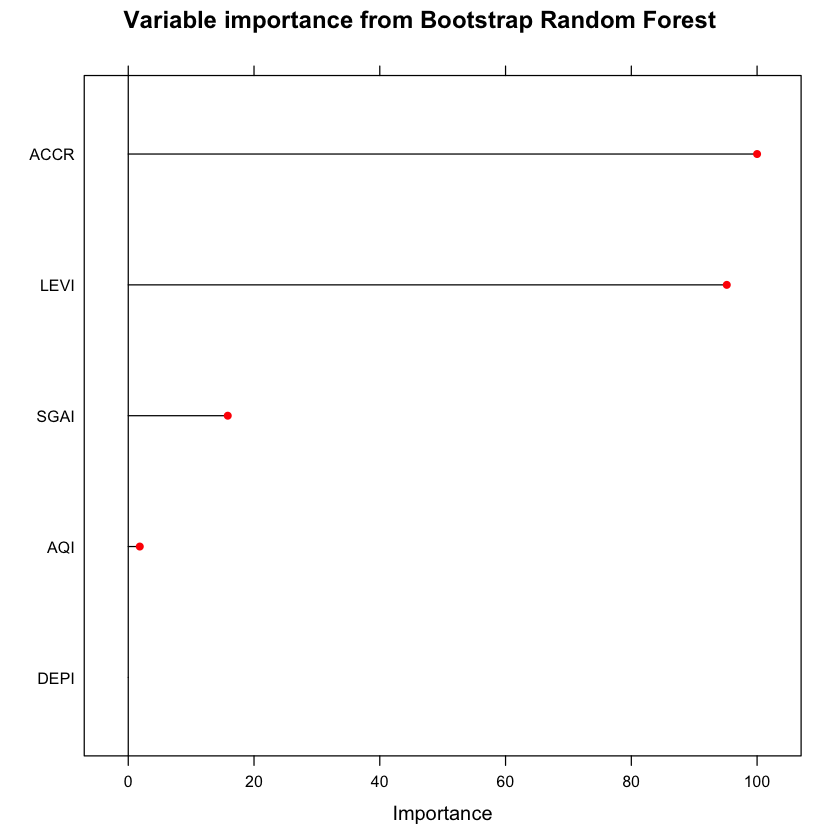

In [13]:
#rf_bootstrap_model$finalModel #rf_bootstrap_model$results
print(rf_bootstrap_model)
confusionMatrix.train(rf_bootstrap_model)
plot(varImp(rf_bootstrap_model), main = "Variable importance from Bootstrap Random Forest", col = 2, lwd = 2)


Confusion Matrix for bootstrap sampling on test set


In [14]:
caretPredictedClass <- predict(rf_bootstrap_model, model_test_df, type = "raw")
confusionMatrix(caretPredictedClass,model_test_df$Manipulater)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  358  10
       Yes   2   1
                                          
               Accuracy : 0.9677          
                 95% CI : (0.9442, 0.9832)
    No Information Rate : 0.9704          
    P-Value [Acc > NIR] : 0.69036         
                                          
                  Kappa : 0.1318          
 Mcnemar's Test P-Value : 0.04331         
                                          
            Sensitivity : 0.99444         
            Specificity : 0.09091         
         Pos Pred Value : 0.97283         
         Neg Pred Value : 0.33333         
             Prevalence : 0.97035         
         Detection Rate : 0.96496         
   Detection Prevalence : 0.99191         
      Balanced Accuracy : 0.54268         
                                          
       'Positive' Class : No              
                                          


ROC plot for bootstrap random forest on test set


An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.8438131


Slot "alpha.values":
list()


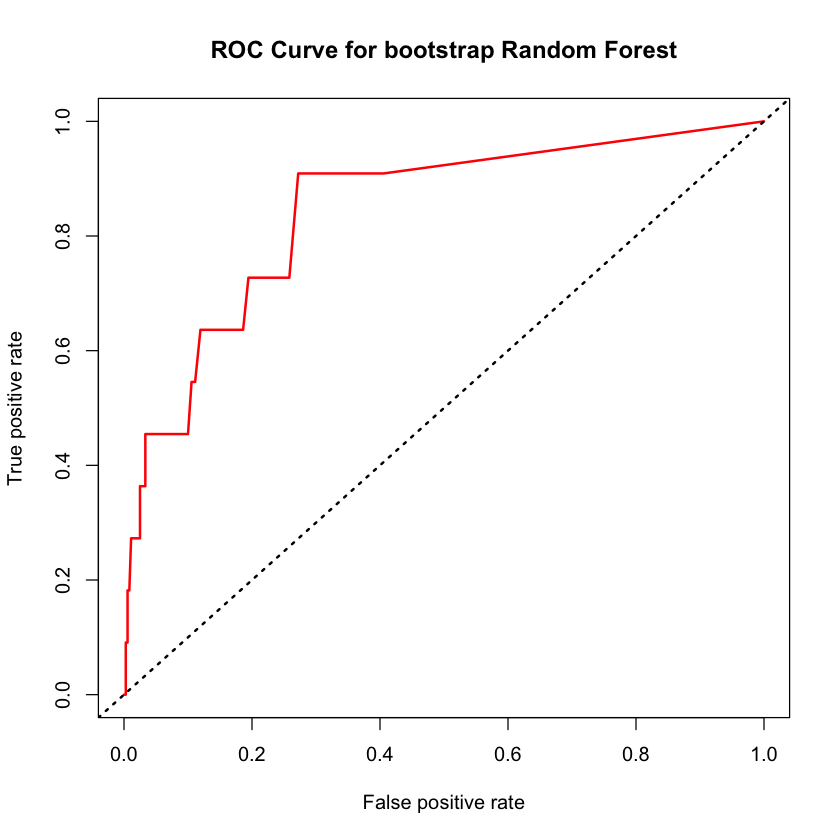

In [15]:
rf_bootstrap_pred <- predict(rf_bootstrap_model, model_test_df, type = "prob")[,2]
rf_bootstrap_prediction <- prediction(rf_bootstrap_pred,model_test_df$Manipulater)
rf_bootstrap_perf <- performance(rf_bootstrap_prediction, "tpr","fpr")

plot(rf_bootstrap_perf,main="ROC Curve for bootstrap Random Forest",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=3,col="black")

#AUC for the ROC plot
performance(rf_bootstrap_prediction, "auc")


The best model was


In [16]:
rf_bootstrap_model$bestTune

,mtry
3,5



Visulaizing the rules coming out of random forest. We can loop and print all the trees built using up sampling. For simplicity, printing just one of the trees



In [17]:
getTree(rf_bootstrap_model$finalModel,3)

,left daughter,right daughter,split var,split point,status,prediction
1,2,3,5,0.337891381,1,0
2,4,5,4,-0.003885957,1,0
3,6,7,5,9.654494271,1,0
4,0,0,0,0.000000000,-1,1
5,0,0,0,0.000000000,-1,2
6,8,9,3,26.834578311,1,0
7,0,0,0,0.000000000,-1,2
8,10,11,4,0.471948375,1,0
9,0,0,0,0.000000000,-1,2
10,12,13,3,0.129103965,1,0



### Random Forest with up sampling
To incorporate up-sampling (sample the minority class to make their frequencies closer to the majority class.), random forest can use an upsampling strategy

The below code chunk sets some of the control parameters


In [18]:
objControl <- trainControl(method='boot', number = 1,
                           returnResamp='final',
                           summaryFunction = twoClassSummary,
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           sampling="up",allowParallel=TRUE)


Parallel processing using doMC needs the below setup:
> * num_cores <- (detectCores()-1)
* registerDoMC(num_cores)

doMC may give added benefit but is OS dependent. May not work on Windows.

The below code chunk uses doParallel library for parallel processing. After setting the control paramters, the model is run


In [19]:
num_cores <- makeCluster(detectCores()-5)
registerDoParallel(num_cores)
tic("RF Bagging with Up Sample")

set.seed(4121)
rf_up_model <- train(model_train_df[,1:5], model_train_df[,6],
                  method='rf',
                  trControl=objControl,
                  metric = "ROC",
                  prox=TRUE)
stopCluster(num_cores)
toc()

RF Bagging with Up Sample: 9.747 sec elapsed



Confusion Matrix for upsampling on train set


Random Forest 

868 samples
  5 predictor
  2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Bootstrapped (1 reps) 
Summary of sample sizes: 868 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec
  2     0.8698770  0.9967213  0   
  3     0.8858607  0.9934426  0   
  5     0.7725410  0.9803279  0   

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 3.


Bootstrapped (1 reps) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   No  Yes
       No  96.8  2.6
       Yes  0.6  0.0
                            
 Accuracy (average) : 0.9681


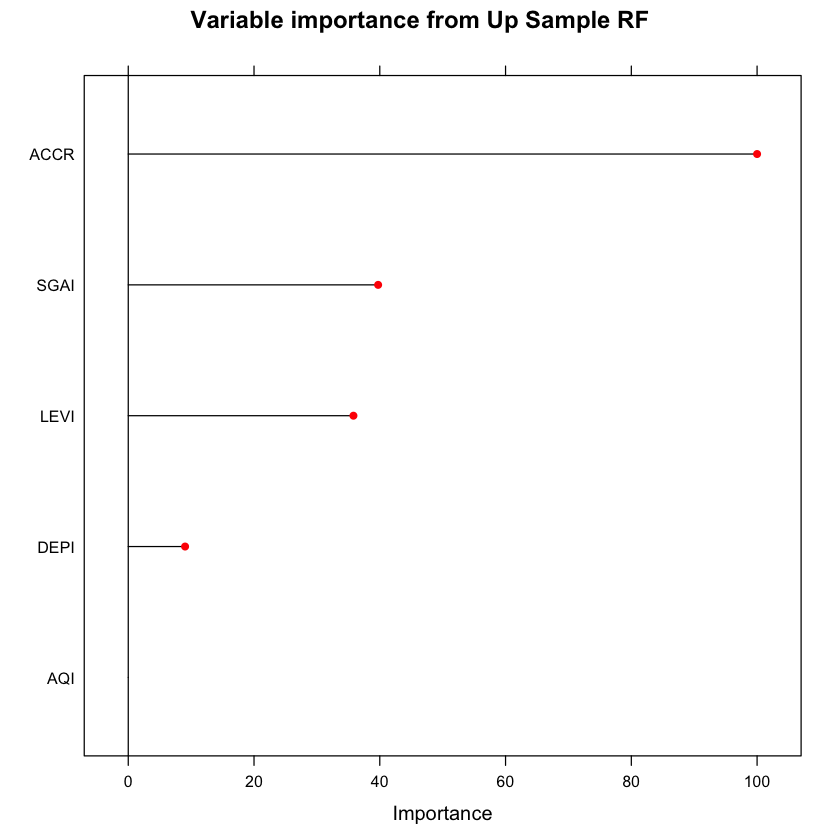

In [20]:
#rf_up_model$finalModel #rf_up_model$results

print(rf_up_model)
confusionMatrix.train(rf_up_model)
plot(varImp(rf_up_model), main = "Variable importance from Up Sample RF", col = 2, lwd = 2)


Confusion Matrix for upsampling on test set


In [21]:
caretPredictedClass <- predict(rf_up_model, model_test_df, type = "raw")
confusionMatrix(caretPredictedClass,model_test_df$Manipulater)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  357  10
       Yes   3   1
                                          
               Accuracy : 0.965           
                 95% CI : (0.9408, 0.9812)
    No Information Rate : 0.9704          
    P-Value [Acc > NIR] : 0.78410         
                                          
                  Kappa : 0.1194          
 Mcnemar's Test P-Value : 0.09609         
                                          
            Sensitivity : 0.99167         
            Specificity : 0.09091         
         Pos Pred Value : 0.97275         
         Neg Pred Value : 0.25000         
             Prevalence : 0.97035         
         Detection Rate : 0.96226         
   Detection Prevalence : 0.98922         
      Balanced Accuracy : 0.54129         
                                          
       'Positive' Class : No              
                                          


ROC plot for upsample random forest on test set


An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.7763889


Slot "alpha.values":
list()


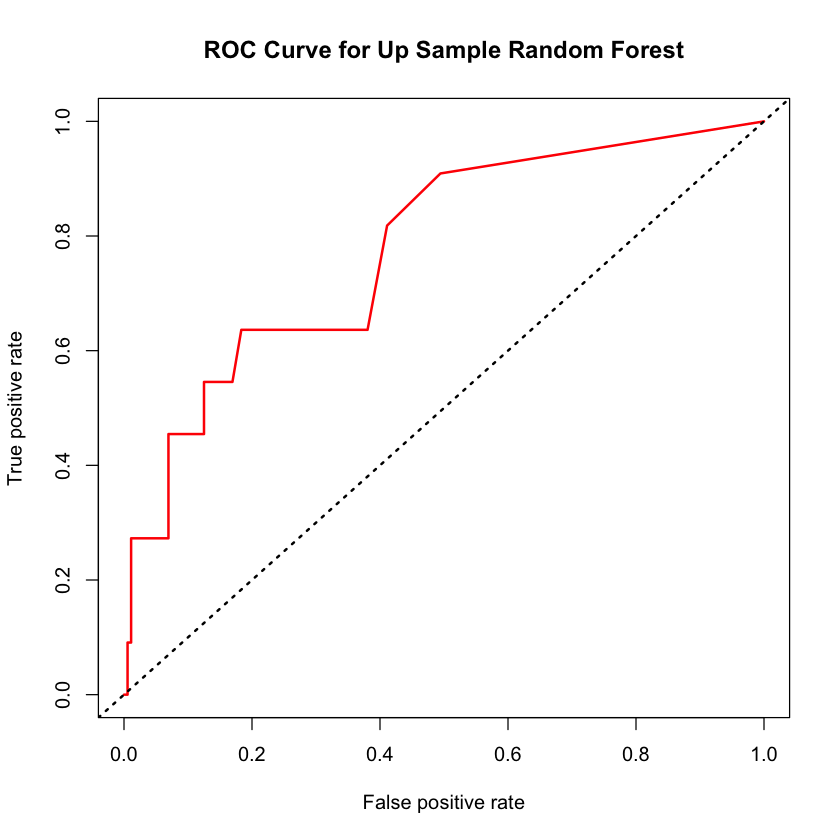

In [22]:
rf_up_pred <- predict(rf_up_model, model_test_df, type = "prob")[,2]
rf_up_prediction <- prediction(rf_up_pred,model_test_df$Manipulater)
rf_up_perf <- performance(rf_up_prediction, "tpr","fpr")

plot(rf_up_perf,main="ROC Curve for Up Sample Random Forest",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=3,col="black")

#AUC for the ROC plot
performance(rf_up_prediction, "auc")


Extracting all the rules from the trees built using random forest


In [23]:
rf_up_treelist <- RF2List(rf_up_model$finalModel)
rf_up_rules <- extractRules(rf_up_treelist,model_train_df[,c(1:5)], ntree = 10)
rf_up_rules_metric <- getRuleMetric(rf_up_rules,model_train_df[,c(1:5)],model_train_df[,6])
rf_up_rules_metric <- pruneRule(rf_up_rules_metric,model_train_df[,c(1:5)],model_train_df[,6])
rf_up_rules_metric <- selectRuleRRF(rf_up_rules_metric,model_train_df[,c(1:5)],model_train_df[,6])

#readable rules
print(presentRules(rf_up_rules_metric, colnames(model_train_df[,c(1:5)])))
#rf.up.learner <- buildLearner(rf.up.rules.metric,model_df[,c(1:6)],model_df[,7])

229 rules (length<=6) were extracted from the first 10 trees.
      len freq    err    
 [1,] "2" "0.007" "0.167"
 [2,] "5" "0.007" "0.167"
 [3,] "2" "0.002" "0"    
 [4,] "2" "0.002" "0"    
 [5,] "1" "0.794" "0.033"
 [6,] "3" "0.002" "0"    
 [7,] "2" "0.001" "0"    
 [8,] "2" "0.001" "0"    
 [9,] "4" "0.003" "0.333"
[10,] "1" "0.679" "0.017"
[11,] "1" "0.594" "0.01" 
[12,] "1" "0.143" "0.048"
[13,] "1" "0.893" "0.025"
      condition                                                                                          
 [1,] "ACCR>-0.0137397365 & LEVI<=0.405980794"                                                           
 [2,] "DEPI<=1.32222965 & DEPI>0.9754958525 & SGAI<=0.672654396 & ACCR>-0.0137397365 & LEVI>1.0273631615"
 [3,] "ACCR<=-0.545217622 & ACCR>-0.637260803"                                                           
 [4,] "AQI>6.559077466 & ACCR<=-0.1654674745"                                                            
 [5,] "DEPI<=1.09348791"                    

### Random Forest with down sampling - First Approach
To incorporate down-sampling (sample the majority class to make their frequencies closer to the minority class.), random forest can use an downsampling strategy

The below code chunk sets some of the control parameters


In [24]:
objControl <- trainControl(method='boot', number = 1,
                           returnResamp='final',
                           summaryFunction = twoClassSummary,
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           sampling="down")


After setting the control parameters, the model is run


In [25]:
num_cores <- makeCluster(detectCores()-5)
registerDoParallel(num_cores)
tic("RF Bagging with Down Sample")

set.seed(4121)
rf_down1_model <- train(model_train_df[,1:5], model_train_df[,6],
                  method='rf',
                  trControl=objControl,
                  metric = "ROC")
stopCluster(num_cores)
toc()

RF Bagging with Down Sample: 3.122 sec elapsed



Confusion Matrix for down sampling RF on train set


Random Forest 

868 samples
  5 predictor
  2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Bootstrapped (1 reps) 
Summary of sample sizes: 868 
Addtional sampling using down-sampling

Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec 
  2     0.7186475  0.8327869  0.375
  3     0.6973361  0.7967213  0.125
  5     0.6540984  0.7639344  0.250

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.


Bootstrapped (1 reps) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   No  Yes
       No  81.2  1.6
       Yes 16.3  1.0
                            
 Accuracy (average) : 0.8211


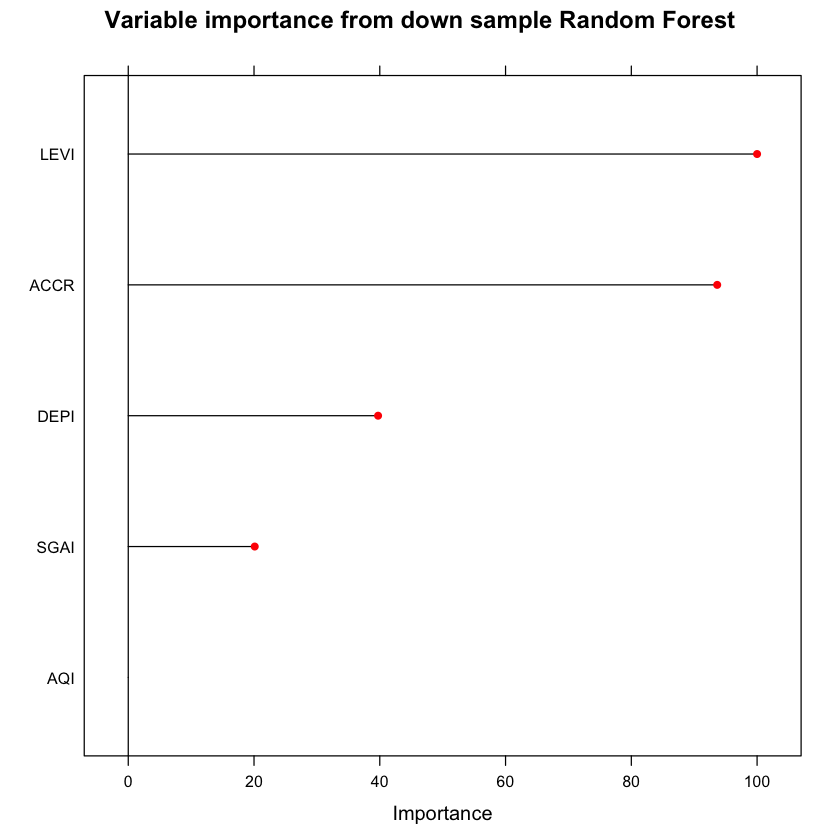

In [26]:
#rf_down1_model$finalModel #rf_down1_model$results
print(rf_down1_model)
confusionMatrix.train(rf_down1_model)
plot(varImp(rf_down1_model), main = "Variable importance from down sample Random Forest", col = 2, lwd = 2)


Confusion Matrix for down sampling RF on test set


In [27]:
caretPredictedClass <- predict(rf_down1_model, model_test_df, type = "raw")
confusionMatrix(caretPredictedClass,model_test_df$Manipulater)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  251   3
       Yes 109   8
                                          
               Accuracy : 0.6981          
                 95% CI : (0.6486, 0.7444)
    No Information Rate : 0.9704          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0749          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.69722         
            Specificity : 0.72727         
         Pos Pred Value : 0.98819         
         Neg Pred Value : 0.06838         
             Prevalence : 0.97035         
         Detection Rate : 0.67655         
   Detection Prevalence : 0.68464         
      Balanced Accuracy : 0.71225         
                                          
       'Positive' Class : No              
                                          


ROC plot for down sample random forest on test set


An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.7656566


Slot "alpha.values":
list()


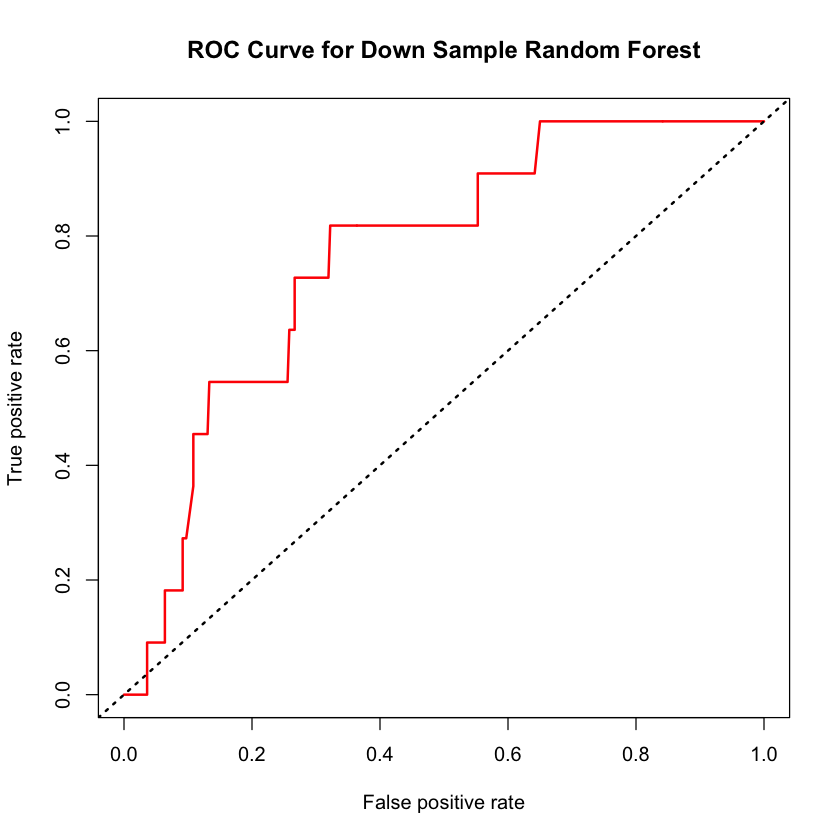

In [28]:
rf_down1_pred <- predict(rf_down1_model, model_test_df, type = "prob")[,2]
rf_down1_prediction <- prediction(rf_down1_pred,model_test_df$Manipulater)
rf_down1_perf <- performance(rf_down1_prediction, "tpr","fpr")

plot(rf_down1_perf,main="ROC Curve for Down Sample Random Forest",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=3,col="black")

#AUC for the ROC plot
performance(rf_down1_prediction, "auc")


### Random Forest with down sampling - Second Approach
To incorporate down-sampling (sample the majority class to make their frequencies closer to the rarest class.), random forest can take a random sample of size c*nmin, where c is the number of classes and nmin is the number of samples in the minority class.

**_THIS IMPLEMENTATION IS WITHOUT CARET PACKAGE_**


In [29]:
nmin <- sum(model_train_df$Manipulater == "Yes") #total minority cases
set.seed(4121)
tic("RF Bagging with Down")
rf_down2_model <- randomForest(Manipulater ~ .,
                         data=model_train_df, importance=TRUE, mtry = 2,
                         #if strata is not defined RF does bootstrap sample
                         strata = model_train_df$Manipulater,
                         #selecting nmin cases from positive and negative class
                         sampsize = rep(nmin,2),
                         #cutoff: ‘winning’ class for an observation is the one
                         #with the maximum ratio of proportion of votes to cutoff.
                         cutoff = c(1/2, 1/2),ntree=1024,  nodesize = 10,
                         keep.forest = TRUE)#, xtest = model_test_df[,-12])
toc()

RF Bagging with Down: 0.162 sec elapsed



Variable importance and Confusion matrix on downsample random forest on train set



Call:
 randomForest(formula = Manipulater ~ ., data = model_train_df,      importance = TRUE, mtry = 2, strata = model_train_df$Manipulater,      sampsize = rep(nmin, 2), cutoff = c(1/2, 1/2), ntree = 1024,      nodesize = 10, keep.forest = TRUE) 
               Type of random forest: classification
                     Number of trees: 1024
No. of variables tried at each split: 2

        OOB estimate of  error rate: 21.54%
Confusion matrix:
     No Yes class.error
No  663 177   0.2107143
Yes  10  18   0.3571429


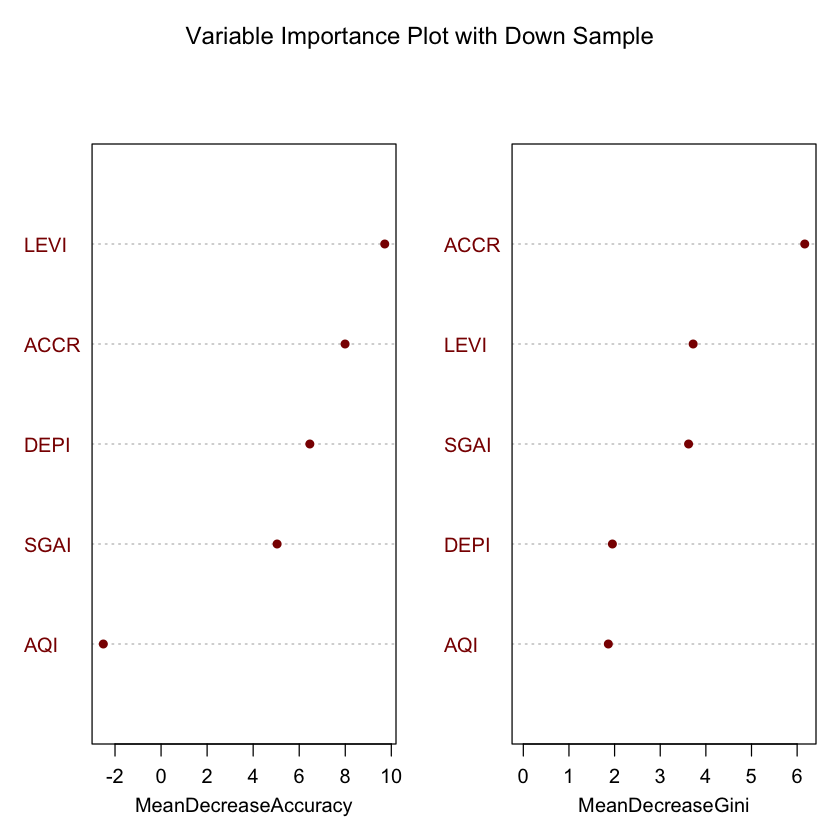

In [30]:
#To plot the error rate.
#plot(rf_down1_model, main = "Error rate vs. number of trees (RF with downsample", type = "l", lwd = 3)

#To know the legends, type rf_down1_model to get the confusion matrix and #see the error

print(rf_down2_model)

varImpPlot(rf_down2_model, main = "Variable Importance Plot with Down Sample", pch = 16, col = 'darkred')



Variable importance and Confusion matrix on downsample random forest on test set


In [31]:
testPredictedClass <- predict(rf_down2_model, model_test_df, type = "response")
confusionMatrix(testPredictedClass,model_test_df$Manipulater)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  275   1
       Yes  85  10
                                          
               Accuracy : 0.7682          
                 95% CI : (0.7219, 0.8102)
    No Information Rate : 0.9704          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1431          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.7639          
            Specificity : 0.9091          
         Pos Pred Value : 0.9964          
         Neg Pred Value : 0.1053          
             Prevalence : 0.9704          
         Detection Rate : 0.7412          
   Detection Prevalence : 0.7439          
      Balanced Accuracy : 0.8365          
                                          
       'Positive' Class : No              
                                          


ROC plot for Random Forest with downsampling on test set


An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.9109848


Slot "alpha.values":
list()


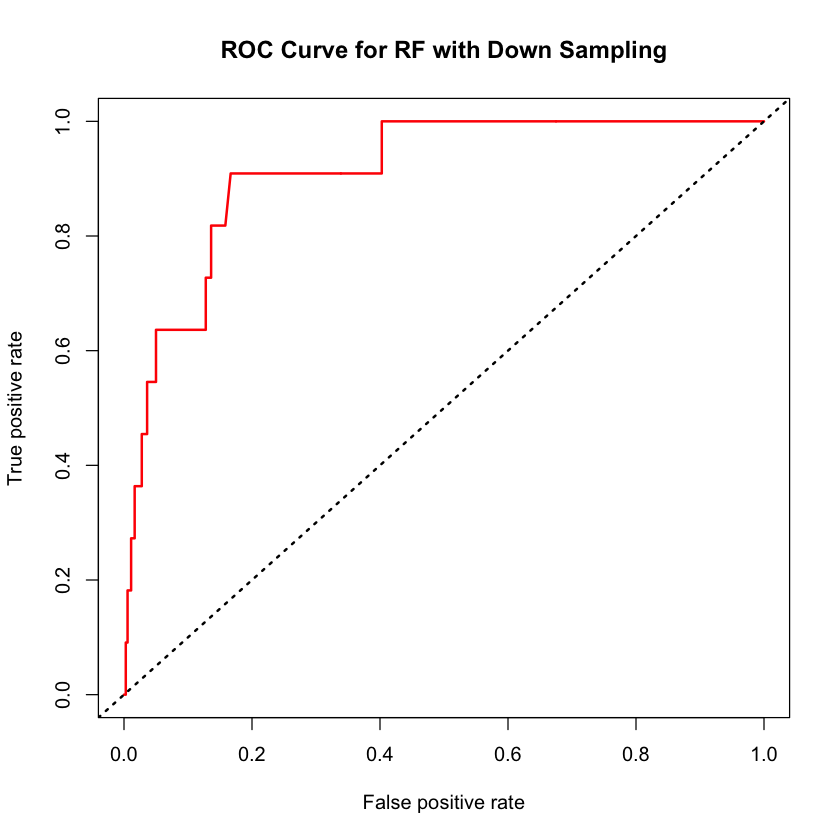

In [32]:
rf_down2_pred <- predict(rf_down2_model, model_test_df, type = "prob")[,2]
rf_down2_prediction <- prediction(rf_down2_pred,model_test_df$Manipulater)
rf_down2_perf <- performance(rf_down2_prediction, "tpr","fpr")

plot(rf_down2_perf,main="ROC Curve for RF with Down Sampling",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=3,col="black")

#AUC for the ROC plot
performance(rf_down2_prediction, "auc")


### Random Forest with SMOTE

Synthetic minority oversampling technique (SMOTE) blends under-sampling of the majority class with a special form of over-sampling the minority class. SMOTE oversamples the rare event by using bootstrapping and k-nearest neighbor to synthetically create additional observations of that event.

The below code chunk sets some of the control parameters


In [33]:
objControl <- trainControl(method='boot', number = 1,
                           returnResamp='final',
                           summaryFunction = twoClassSummary,
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           sampling="smote")


After setting the control parameters, the model is run


In [34]:
num_cores <- makeCluster(detectCores()-5)
registerDoParallel(num_cores)
tic("RF Bagging with SMOTE Sample")

set.seed(4121)
rf_smote_model <- train(model_train_df[,1:5], model_train_df[,6],
                  method='rf',
                  trControl=objControl,
                  metric = "ROC",
                  prox=TRUE,allowParallel=TRUE)
stopCluster(num_cores)
toc()

RF Bagging with SMOTE Sample: 3.496 sec elapsed



Confusion Matrix for RF on train set


Random Forest 

868 samples
  5 predictor
  2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Bootstrapped (1 reps) 
Summary of sample sizes: 868 
Addtional sampling using SMOTE

Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec 
  2     0.7354508  0.8819672  0.125
  3     0.6907787  0.8852459  0.125
  5     0.7579918  0.8852459  0.250

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 5.


Bootstrapped (1 reps) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   No  Yes
       No  86.3  1.9
       Yes 11.2  0.6
                           
 Accuracy (average) : 0.869


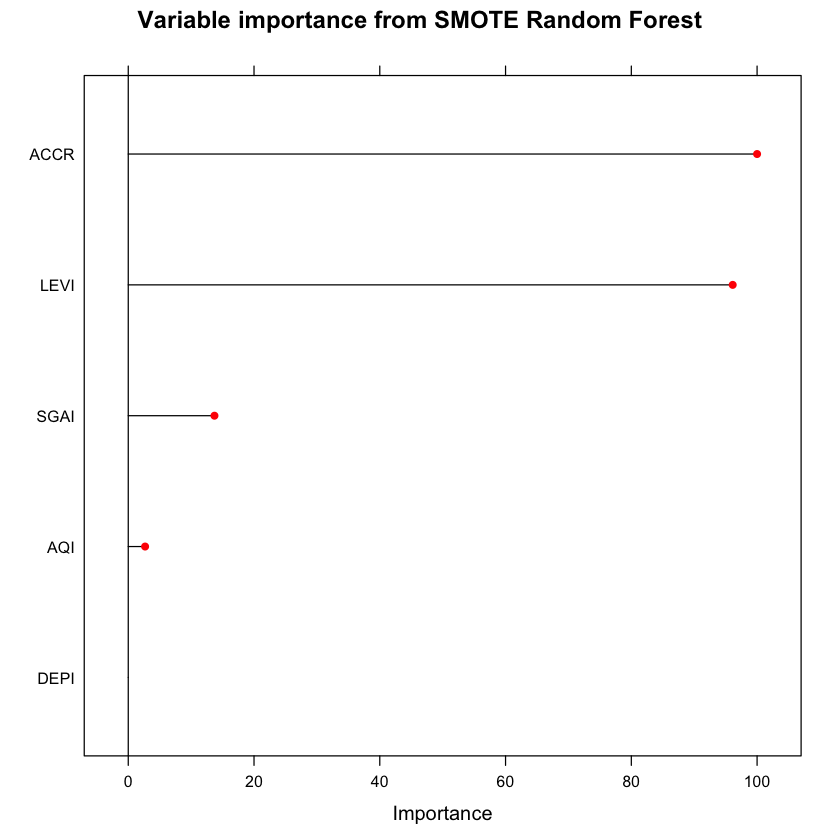

In [35]:
#rf_smote_model$finalModel #rf_smote_model$results
print(rf_smote_model)
confusionMatrix.train(rf_smote_model)
plot(varImp(rf_smote_model), main = "Variable importance from SMOTE Random Forest", col = 2, lwd = 2)


Confusion Matrix for RF on test set


In [36]:
caretPredictedClass <- predict(rf_smote_model, model_test_df, type = "raw")
confusionMatrix(caretPredictedClass,model_test_df$Manipulater)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  292   5
       Yes  68   6
                                          
               Accuracy : 0.8032          
                 95% CI : (0.7591, 0.8425)
    No Information Rate : 0.9704          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0944          
 Mcnemar's Test P-Value : 3.971e-13       
                                          
            Sensitivity : 0.81111         
            Specificity : 0.54545         
         Pos Pred Value : 0.98316         
         Neg Pred Value : 0.08108         
             Prevalence : 0.97035         
         Detection Rate : 0.78706         
   Detection Prevalence : 0.80054         
      Balanced Accuracy : 0.67828         
                                          
       'Positive' Class : No              
                                          


ROC plot for random forest on test set


An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.8258838


Slot "alpha.values":
list()


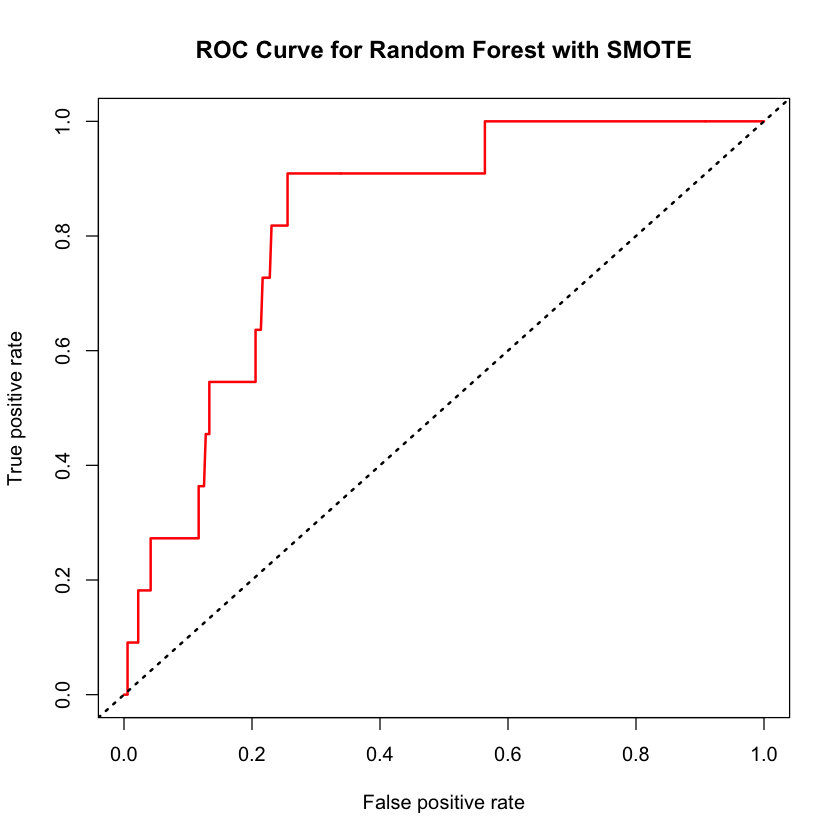

In [37]:
rf_smote_pred <- predict(rf_smote_model, model_test_df, type = "prob")[,2]
rf_smote_prediction <- prediction(rf_smote_pred,model_test_df$Manipulater)
rf_smote_perf <- performance(rf_smote_prediction, "tpr","fpr")

plot(rf_smote_perf,main="ROC Curve for Random Forest with SMOTE",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=3,col="black")

#AUC for the ROC plot
performance(rf_smote_prediction, "auc")


## Boosting
Boosting is an ensemble technique which tries to create a strong classifier from several weak classifier. The model buidling through boosting is sequential.
1. The first model is build based on the random sample on N observations picked from original dataset (with replacement). Equal weight is assigned to each observation. These weights decide the probability of observations which will be picked up in the training set.
2. In the second step, all the original dataset is passed through the model. For regressor model, the observations whose predicted value differs the most from the actual value is defined to be most in error.
3. The sampling probabilities of the observations which are most in error, is adjusted such that their chance of getting picked up for the second model is higher.
4. As the model buidling progresses, in each of the sequence of models, the pattern which are more difficult are picked up. Different models are better in different part of the observation space.
5. Rgeressors are combined using weighted median. Models which are more confident about their predictions are weighted more heavily.

### Boosting algorithms in R
Adaboost is one of the ways to boost the performance of decision trees on binary classification problems. The decision trees with just one level will mostly be a weak learner. These weak learners will achieve an accuracy just above random chance on a classification problem.

Adaboost is also referred to as discrete AdaBoost as it is used for classification rather than regression. The algorithms in boosting are:

> 1. Adaboost classification trees: **_adaboost()_** Required Package is **fastAdaboost**
2. Adaboost.M1: **_AdaBoost.M1()_** Required Package is **adabag, plyr**
3. Boosted Classification Trees: **_ada()_** Required Package is **adabag, plyr**
4. Boosted Generalized Additive Model: **_gamBoost()_** Required Package is **mboost, plyr**
5. Boosted Generalized Linear Model: **_glmboost()_** Required Package is **mboost, plyr**
6. Boosted Linear Model: **_Bstlm()_** Required Package is **bst, plyr**
7. Boosted Logistic Regression: **_LogitBoost()_** Required Package is **caTools**
8. Boosted Smoothing Spline: **_bstSm()_** Required Package is **bst, plyr**
9. Boosted Tree: **_blackboost()_** Required Package is **party, mboost, plyr**
10. Boosted Tree: **_bstTree()_** Required Package is **bst, plyr**
11. C5.0: **_C5.0()_** Required Package is **C50, plyr**
12. Cost Sensitive C5.0: **_C5.0Cost()_** Required Package is **C50, plyr**
13. Cubist: **_glmboost()_** Required Package is **cubist**
14. DeepBoost: **_deepboost()_** Required Package is **deepboost**
15. eXtreme Gradient Boosting: **_xgbLinear()_** Required Package is **xgboost**
16. eXtreme Gradient Boosting: **_xgbTree()_** Required Package is **xgboost, plyr**
17. Stochastic Gradient Boosting: **_gbm()_** Required Package is **gbm, plyr**

### Boosting with adaboost (normal )
The below code chunk sets some of the control parameters for adaboost


In [38]:
objControl <- trainControl(method='boot', number = 1,
                           returnResamp='all',
                           summaryFunction = twoClassSummary,
                           savePredictions = TRUE,
                           classProbs = TRUE)#, p = 0.70) #in case method = #"LGOCV"

In [39]:
search_grid <- expand.grid(mfinal = c(20:100), maxdepth = c(2:4),
                    coeflearn = c("Breiman", "Freund", "Zhu"))


Look for the documentation of library **adabag**. The **boosting()** function of adabag implments 'AdaBoost.M1'. The *boos* paramter of boosting function is set to TRUE by default. This meand a bootstrap sample of the training set is drawn using the weights for each observation on that iteration. If FALSE, every observation is used with its weights.

After setting the control paramters, the model is run


In [40]:
num_cores <- makeCluster(detectCores()-5)
registerDoParallel(num_cores)
tic("Adaptive Boosting with Bootstrap Sample")

set.seed(4121)
ada_model <- train(model_train_df[,1:5], model_train_df[,6],
                  method='AdaBoost.M1',
                  trControl=objControl,
                  tuneGrid = search_grid,
                  metric = "ROC")
stopCluster(num_cores)
toc()

Adaptive Boosting with Bootstrap Sample: 121.42 sec elapsed



Confusion Matrix for adaboost on train set


AdaBoost.M1 

868 samples
  5 predictor
  2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Bootstrapped (1 reps) 
Summary of sample sizes: 868 
Resampling results across tuning parameters:

  coeflearn  maxdepth  mfinal  ROC        Sens       Spec 
  Breiman    2          20     0.6795082  1.0000000  0.000
  Breiman    2          21     0.6827869  1.0000000  0.000
  Breiman    2          22     0.6774590  1.0000000  0.000
  Breiman    2          23     0.6676230  1.0000000  0.000
  Breiman    2          24     0.7036885  1.0000000  0.000
  Breiman    2          25     0.6889344  1.0000000  0.000
  Breiman    2          26     0.6885246  1.0000000  0.000
  Breiman    2          27     0.6905738  1.0000000  0.000
  Breiman    2          28     0.6913934  0.9967213  0.000
  Breiman    2          29     0.6942623  1.0000000  0.000
  Breiman    2          30     0.6729508  0.9967213  0.000
  Breiman    2          31     0.6729508  0.9967213  0.000
  Breiman    2          32     0.6729

Bootstrapped (1 reps) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   No  Yes
       No  96.8  2.6
       Yes  0.6  0.0
                            
 Accuracy (average) : 0.9681


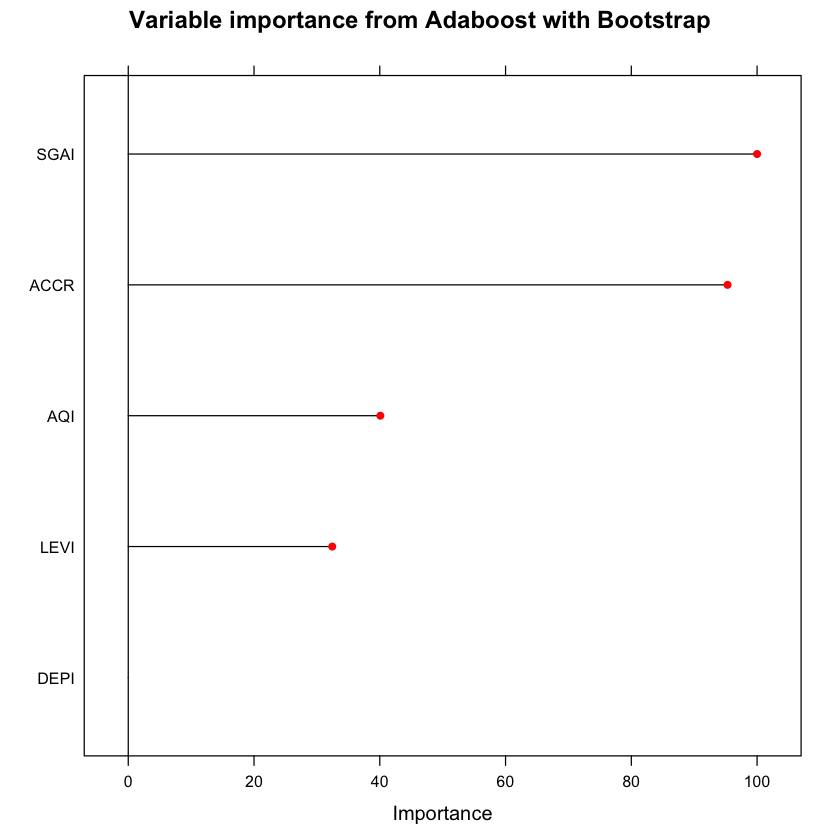

In [41]:
#ada_model$finalModel #ada_model$results
print(ada_model)
confusionMatrix.train(ada_model)
plot(varImp(ada_model), main = "Variable importance from Adaboost with Bootstrap", col = 2, lwd = 2)


Confusion Matrix for adaboost on test set


In [42]:
caretPredictedClass <- predict(ada_model, model_test_df, type = "raw")
confusionMatrix(caretPredictedClass,model_test_df$Manipulater)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  356   9
       Yes   4   2
                                          
               Accuracy : 0.965           
                 95% CI : (0.9408, 0.9812)
    No Information Rate : 0.9704          
    P-Value [Acc > NIR] : 0.7841          
                                          
                  Kappa : 0.2189          
 Mcnemar's Test P-Value : 0.2673          
                                          
            Sensitivity : 0.9889          
            Specificity : 0.1818          
         Pos Pred Value : 0.9753          
         Neg Pred Value : 0.3333          
             Prevalence : 0.9704          
         Detection Rate : 0.9596          
   Detection Prevalence : 0.9838          
      Balanced Accuracy : 0.5854          
                                          
       'Positive' Class : No              
                                          


ROC plot for adaboost on test set


An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.7848485


Slot "alpha.values":
list()


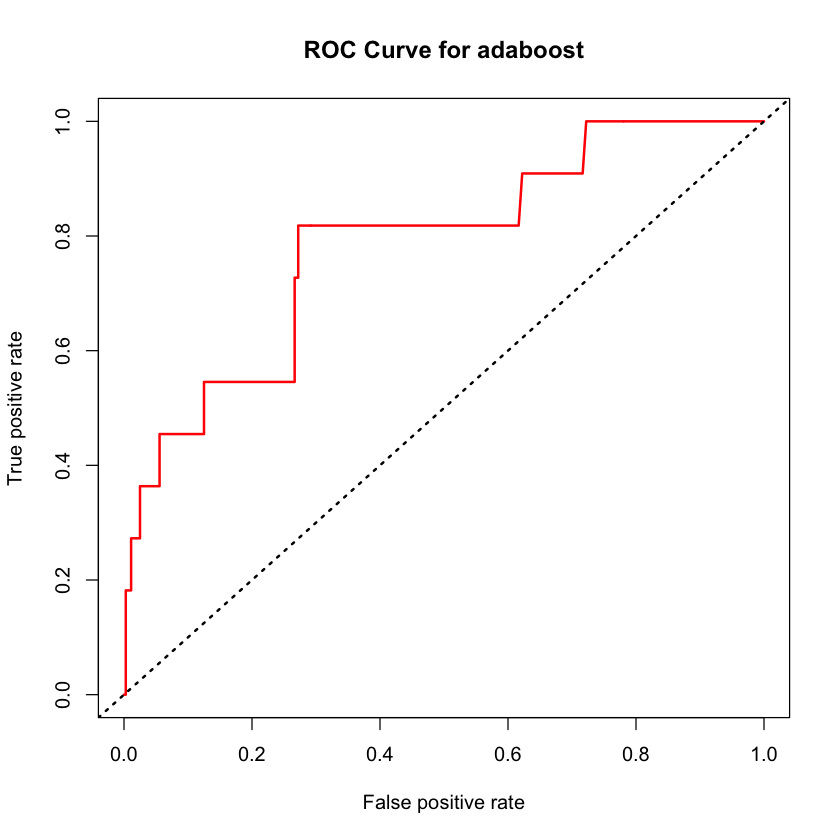

In [43]:
ada_pred <- predict(ada_model, model_test_df, type = "prob")[,2]
ada_prediction <- prediction(ada_pred,model_test_df$Manipulater)
ada_perf <- performance(ada_prediction, "tpr","fpr")

plot(ada_perf,main="ROC Curve for adaboost",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=3,col="black")

#AUC for the ROC plot
performance(ada_prediction, "auc")


Visulaizing the rules coming out of ada boost. We can loop and print all the trees which was built using boosting. For simplicity, we are printing just one of the trees

To retrieve the understand any model specific attribute, we have to call the **$finalmodel** of the train object created using caret package. This is a generic way to use functions which are model specific. Here **get_tree()** is a function of **fastadaboost** package which cannot be used unless the the object returned is not of adaboost class.



In [44]:
#listTreesAda(ada_model$finalModel,3) #this is a function with rattle package
#get_tree(ada_model$finalModel,2)


### Boosting with adaboost (upsample)
The below code chunk sets some of the control parameters for adaboost


In [45]:
objControl <- trainControl(method='boot', number = 1,
                           returnResamp='all',
                           summaryFunction = twoClassSummary,
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           sampling = "up")#, p = 0.70) #in case method = #"LGOCV"

In [46]:
search_grid <- expand.grid(mfinal = c(20:100), maxdepth = c(2:4),
                    coeflearn = c("Breiman", "Freund", "Zhu"))


After setting the control paramters, the model is run


In [47]:
num_cores <- makeCluster(detectCores()-5)
registerDoParallel(num_cores)
tic("Adaptive Boosting with UP Sample")

set.seed(4121)
ada_up_model <- train(model_train_df[,1:5], model_train_df[,6],
                  method='AdaBoost.M1',
                  trControl=objControl,
                  tuneGrid = search_grid,
                  metric = "ROC")
stopCluster(num_cores)
toc()

Adaptive Boosting with UP Sample: 116.933 sec elapsed



Confusion Matrix for adaboost on train set


AdaBoost.M1 

868 samples
  5 predictor
  2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Bootstrapped (1 reps) 
Summary of sample sizes: 868 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  coeflearn  maxdepth  mfinal  ROC        Sens       Spec 
  Breiman    2          20     0.7114754  0.9245902  0.000
  Breiman    2          21     0.7135246  0.9278689  0.125
  Breiman    2          22     0.7135246  0.9344262  0.000
  Breiman    2          23     0.6938525  0.9311475  0.000
  Breiman    2          24     0.6938525  0.9311475  0.000
  Breiman    2          25     0.6821721  0.9344262  0.000
  Breiman    2          26     0.6903689  0.9409836  0.000
  Breiman    2          27     0.6934426  0.9409836  0.000
  Breiman    2          28     0.6926230  0.9344262  0.000
  Breiman    2          29     0.6926230  0.9475410  0.000
  Breiman    2          30     0.6868852  0.9442623  0.000
  Breiman    2          31     0.6868852  0.9475410  0.000

Bootstrapped (1 reps) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   No  Yes
       No  91.7  2.2
       Yes  5.8  0.3
                            
 Accuracy (average) : 0.9201


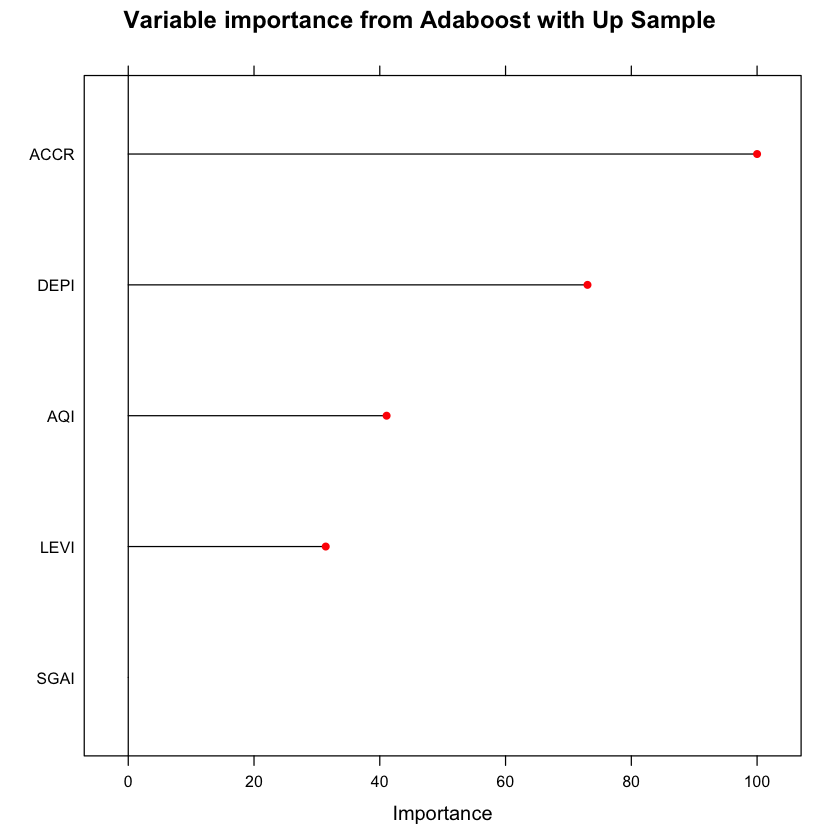

In [48]:
#ada_up_model$finalModel #ada_up_model$results
print(ada_up_model)
confusionMatrix.train(ada_up_model)
plot(varImp(ada_up_model), main = "Variable importance from Adaboost with Up Sample", col = 2, lwd = 2)


Confusion Matrix for adaboost on test set


In [49]:
caretPredictedClass <- predict(ada_up_model, model_test_df, type = "raw")
confusionMatrix(caretPredictedClass,model_test_df$Manipulater)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  343   7
       Yes  17   4
                                          
               Accuracy : 0.9353          
                 95% CI : (0.9053, 0.9581)
    No Information Rate : 0.9704          
    P-Value [Acc > NIR] : 0.99985         
                                          
                  Kappa : 0.2196          
 Mcnemar's Test P-Value : 0.06619         
                                          
            Sensitivity : 0.9528          
            Specificity : 0.3636          
         Pos Pred Value : 0.9800          
         Neg Pred Value : 0.1905          
             Prevalence : 0.9704          
         Detection Rate : 0.9245          
   Detection Prevalence : 0.9434          
      Balanced Accuracy : 0.6582          
                                          
       'Positive' Class : No              
                                          


ROC plot for adaboost on test set


An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.7568182


Slot "alpha.values":
list()


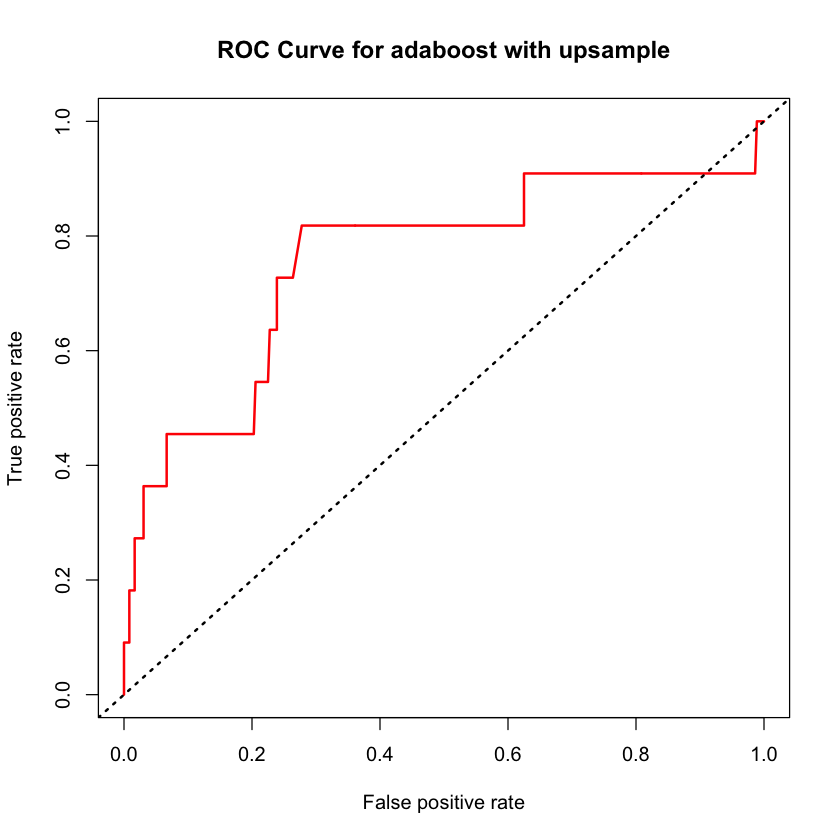

In [50]:
ada_pred <- predict(ada_up_model, model_test_df, type = "prob")[,2]
ada_prediction <- prediction(ada_pred,model_test_df$Manipulater)
ada_perf <- performance(ada_prediction, "tpr","fpr")

plot(ada_perf,main="ROC Curve for adaboost with upsample",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=3,col="black")

#AUC for the ROC plot
performance(ada_prediction, "auc")


### Boosting with adaboost (down sample)
The below code chunk sets some of the control parameters for adaboost


In [51]:
objControl <- trainControl(method='boot', number = 1,
                           returnResamp='all',
                           summaryFunction = twoClassSummary,
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           sampling = "down")#, p = 0.70) #in case method = #"LGO"

In [52]:
search_grid <- expand.grid(mfinal = c(20:100), maxdepth = c(2:4),
                    coeflearn = c("Breiman", "Freund", "Zhu"))


After setting the control paramters, the model is run


In [53]:
num_cores <- makeCluster(detectCores()-5)
registerDoParallel(num_cores)
tic("Adaptive Boosting with Down Sample")

set.seed(4121)
ada_down.model <- train(model_train_df[,1:5], model_train_df[,6],
                  method='AdaBoost.M1',
                  trControl=objControl,
                  tuneGrid = search_grid,
                  metric = "ROC")
stopCluster(num_cores)
toc()

Adaptive Boosting with Down Sample: 137.311 sec elapsed



Confusion Matrix for adaboost on train set


AdaBoost.M1 

868 samples
  5 predictor
  2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Bootstrapped (1 reps) 
Summary of sample sizes: 868 
Addtional sampling using down-sampling

Resampling results across tuning parameters:

  coeflearn  maxdepth  mfinal  ROC        Sens       Spec 
  Breiman    2          20     0.6885246  0.7770492  0.375
  Breiman    2          21     0.6721311  0.7737705  0.375
  Breiman    2          22     0.6817623  0.7836066  0.375
  Breiman    2          23     0.6764344  0.7836066  0.375
  Breiman    2          24     0.6362705  0.7540984  0.375
  Breiman    2          25     0.6350410  0.7836066  0.250
  Breiman    2          26     0.6399590  0.7803279  0.250
  Breiman    2          27     0.6301230  0.7803279  0.250
  Breiman    2          28     0.6354508  0.7868852  0.250
  Breiman    2          29     0.6481557  0.8032787  0.250
  Breiman    2          30     0.6625000  0.7967213  0.250
  Breiman    2          31     0.6760246  0.8000000  0.2

Bootstrapped (1 reps) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   No  Yes
       No  77.3  1.6
       Yes 20.1  1.0
                            
 Accuracy (average) : 0.7827


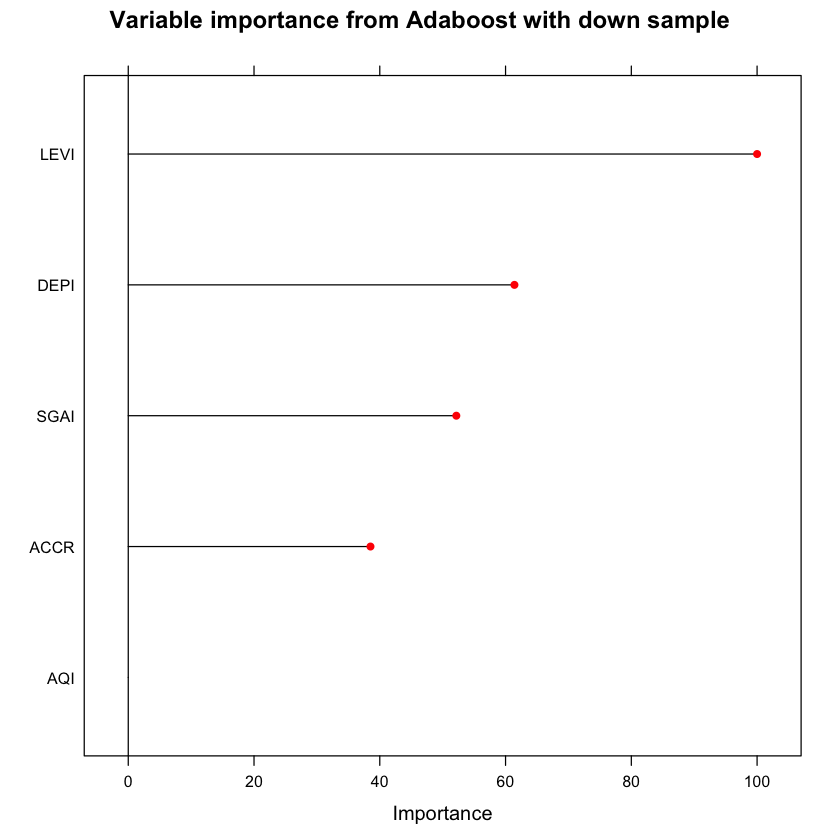

In [54]:
#ada_down.model$finalModel #ada_down.model$results
print(ada_down.model)
confusionMatrix.train(ada_down.model)
plot(varImp(ada_down.model), main = "Variable importance from Adaboost with down sample", col = 2, lwd = 2)


Confusion Matrix for adaboost on test set


In [55]:
caretPredictedClass <- predict(ada_down.model, model_test_df, type = "raw")
confusionMatrix(caretPredictedClass,model_test_df$Manipulater)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  261   2
       Yes  99   9
                                          
               Accuracy : 0.7278          
                 95% CI : (0.6794, 0.7724)
    No Information Rate : 0.9704          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.103           
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.72500         
            Specificity : 0.81818         
         Pos Pred Value : 0.99240         
         Neg Pred Value : 0.08333         
             Prevalence : 0.97035         
         Detection Rate : 0.70350         
   Detection Prevalence : 0.70889         
      Balanced Accuracy : 0.77159         
                                          
       'Positive' Class : No              
                                          


ROC plot for adaboost on test set


An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.8616162


Slot "alpha.values":
list()


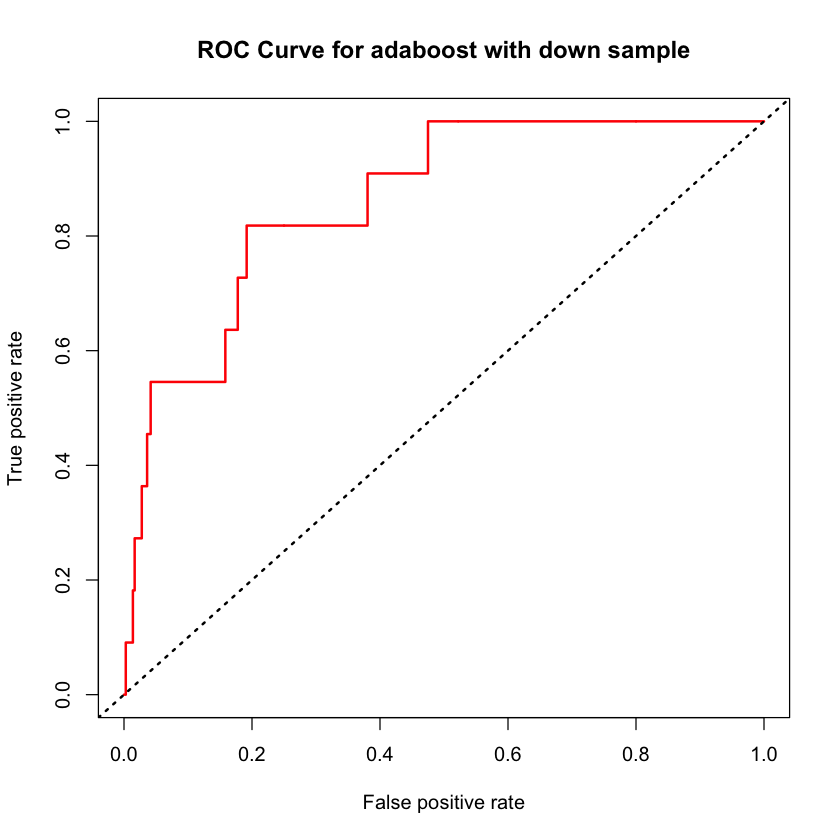

In [56]:
ada_pred <- predict(ada_down.model, model_test_df, type = "prob")[,2]
ada_prediction <- prediction(ada_pred,model_test_df$Manipulater)
ada_perf <- performance(ada_prediction, "tpr","fpr")

plot(ada_perf,main="ROC Curve for adaboost with down sample",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=3,col="black")

#AUC for the ROC plot
performance(ada_prediction, "auc")


### Boosting with adaboost (SMOTE)
The below code chunk sets some of the control parameters for adaboost


In [57]:
objControl <- trainControl(method='boot', number = 1,
                           returnResamp='all',
                           summaryFunction = twoClassSummary,
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           sampling = "smote")#, p = 0.70) #in case method = #"LGO"

In [58]:
search_grid <- expand.grid(mfinal = c(20:100), maxdepth = c(2:4),
                    coeflearn = c("Breiman", "Freund", "Zhu"))


After setting the control paramters, the model is run


In [59]:
num_cores <- makeCluster(detectCores()-5)
registerDoParallel(num_cores)
tic("Adaptive Boosting with SMOTE")

set.seed(4121)
ada_smote_model <- train(model_train_df[,1:5], model_train_df[,6],
                  method='AdaBoost.M1',
                  trControl=objControl,
                  tuneGrid = search_grid,
                  metric = "ROC")
stopCluster(num_cores)
toc()

Adaptive Boosting with SMOTE: 123.87 sec elapsed



Confusion Matrix for adaboost on train set


AdaBoost.M1 

868 samples
  5 predictor
  2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Bootstrapped (1 reps) 
Summary of sample sizes: 868 
Addtional sampling using SMOTE

Resampling results across tuning parameters:

  coeflearn  maxdepth  mfinal  ROC        Sens       Spec 
  Breiman    2          20     0.6805328  0.8262295  0.250
  Breiman    2          21     0.6838115  0.8590164  0.125
  Breiman    2          22     0.6547131  0.8590164  0.125
  Breiman    2          23     0.6555328  0.8622951  0.000
  Breiman    2          24     0.6629098  0.8721311  0.000
  Breiman    2          25     0.6612705  0.8852459  0.000
  Breiman    2          26     0.6657787  0.8754098  0.000
  Breiman    2          27     0.6764344  0.8459016  0.125
  Breiman    2          28     0.6784836  0.8622951  0.000
  Breiman    2          29     0.6522541  0.8491803  0.125
  Breiman    2          30     0.6534836  0.8688525  0.000
  Breiman    2          31     0.6532787  0.8688525  0.125
  Bre

Bootstrapped (1 reps) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   No  Yes
       No  84.3  1.6
       Yes 13.1  1.0
                           
 Accuracy (average) : 0.853


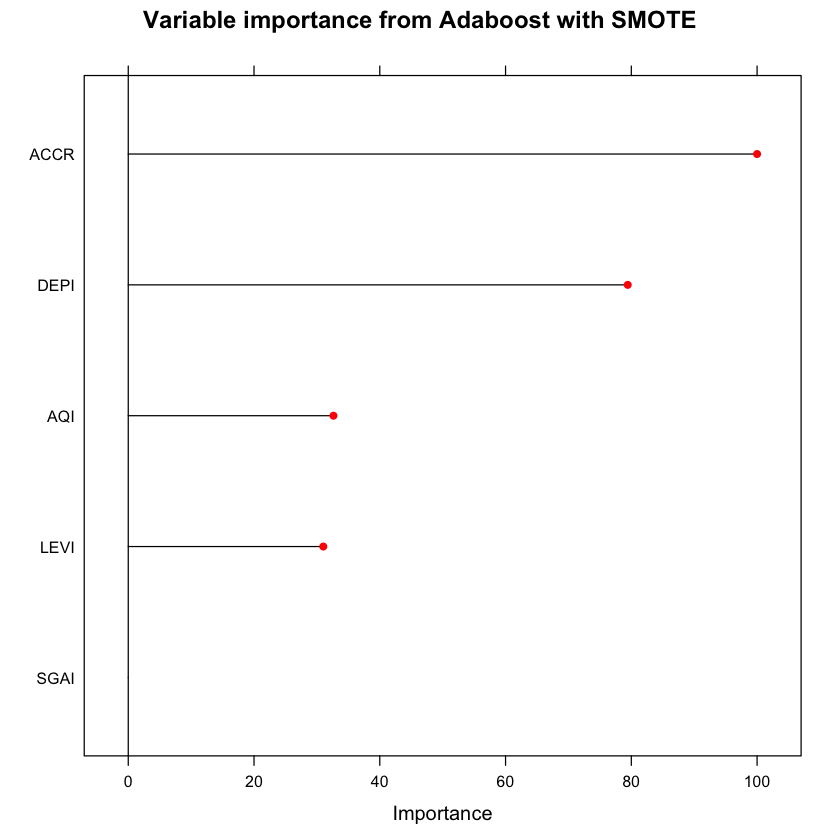

In [60]:
#ada_smote_model$finalModel #ada_smote_model$results
print(ada_smote_model)
confusionMatrix.train(ada_smote_model)
plot(varImp(ada_smote_model), main = "Variable importance from Adaboost with SMOTE", col = 2, lwd = 2)


Confusion Matrix for adaboost on test set


In [61]:
caretPredictedClass <- predict(ada_smote_model, model_test_df, type = "raw")
confusionMatrix(caretPredictedClass,model_test_df$Manipulater)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  289   4
       Yes  71   7
                                          
               Accuracy : 0.7978          
                 95% CI : (0.7533, 0.8375)
    No Information Rate : 0.9704          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1111          
 Mcnemar's Test P-Value : 2.517e-14       
                                          
            Sensitivity : 0.80278         
            Specificity : 0.63636         
         Pos Pred Value : 0.98635         
         Neg Pred Value : 0.08974         
             Prevalence : 0.97035         
         Detection Rate : 0.77898         
   Detection Prevalence : 0.78976         
      Balanced Accuracy : 0.71957         
                                          
       'Positive' Class : No              
                                          


ROC plot for adaboost on test set


An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.8828283


Slot "alpha.values":
list()


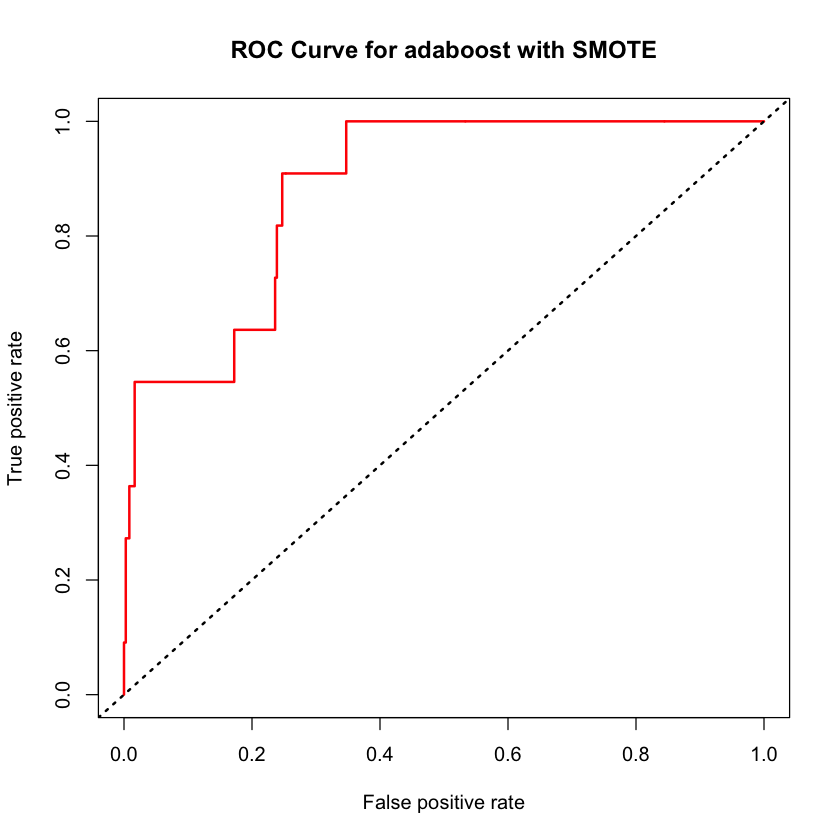

In [62]:
ada_pred <- predict(ada_smote_model, model_test_df, type = "prob")[,2]
ada_prediction <- prediction(ada_pred,model_test_df$Manipulater)
ada_perf <- performance(ada_prediction, "tpr","fpr")

plot(ada_perf,main="ROC Curve for adaboost with SMOTE",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=3,col="black")

#AUC for the ROC plot
performance(ada_prediction, "auc")


### Boosting with xgboost (normal)

Look for the documentation of library **xgboost**. The **xgb.train()** function of xgboost implments 'xgbTree'(Default) and 'xgbLinear'.




1. [Refer](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) to know about the fine tuning parameters.
2. [This](http://topepo.github.io/caret/train-models-by-tag.html#Boosting) can also be referred to know about the parameter fine tuning.


For xgbTree the fine tuning paramter consists of:

> 1. eta control the learning rate: scale the contribution of each tree by a factor of 0 < eta < 1 when it is added to the current approximation. Used to prevent overfitting by making the boosting process more conservative. Lower value for eta implies larger value for nrounds: low eta value means model more robust to overfitting but slower to compute. Default: 0.3
2. gamma minimum loss reduction required to make a further partition on a leaf node of the tree. the larger, the more conservative the algorithm will be.
3. max_depth maximum depth of a tree. Default: 6
4. min_child_weight minimum sum of instance weight(hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression mode, this simply corresponds to minimum number of instances needed to be in each node. The larger, the more conservative the algorithm will be. Default: 1
5. subsample subsample ratio of the training instance. Setting it to 0.5 means that xgboost randomly collected half of the data instances to grow trees and this will prevent overfitting. It makes computation shorter (because less data to analyse). It is advised to use this parameter with eta and increase nround. Default: 1
6. colsample_bytree subsample ratio of columns when constructing each tree. Default: 1
7. num_parallel_tree Experimental parameter. number of trees to grow per round. Useful to test Random Forest through Xgboost (set colsample_bytree < 1, subsample < 1 and round = 1) accordingly. Default: 1

The below code chunk sets some of the control parameters for adaboost

In [63]:
objControl <- trainControl(method='boot', number = 1,
                           returnResamp='final',
                           summaryFunction = twoClassSummary,
                           savePredictions = TRUE,
                           classProbs = TRUE)

In [64]:
search_grid <- expand.grid(nrounds = c(70:150), max_depth = c(2:4),
                    eta = c(0.1,0.3,0.5),
                    gamma = c(0.03,0.09, 0.12),
                    colsample_bytree = c(5:10)/10,
                    min_child_weight = c(1:5),
                    subsample = c(0.5))


After setting the control paramters, the model is run


In [65]:
num_cores <- makeCluster(detectCores()-5)
registerDoParallel(num_cores)
tic("Xtreme Boosting with Bootstrap Sampling")

set.seed(4121)
xg_model <- train(model_train_df[,1:5], model_train_df[,6],
                  method='xgbTree',
                  trControl=objControl,
                  tuneGrid = search_grid,
                  metric = "ROC")
stopCluster(num_cores)
toc()

Xtreme Boosting with Bootstrap Sampling: 246.938 sec elapsed



Confusion Matrix for xgboost on train set


,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
16628,92,4,0.1,0.03,1,1,0.5


Bootstrapped (1 reps) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   No  Yes
       No  97.1  2.6
       Yes  0.3  0.0
                            
 Accuracy (average) : 0.9712


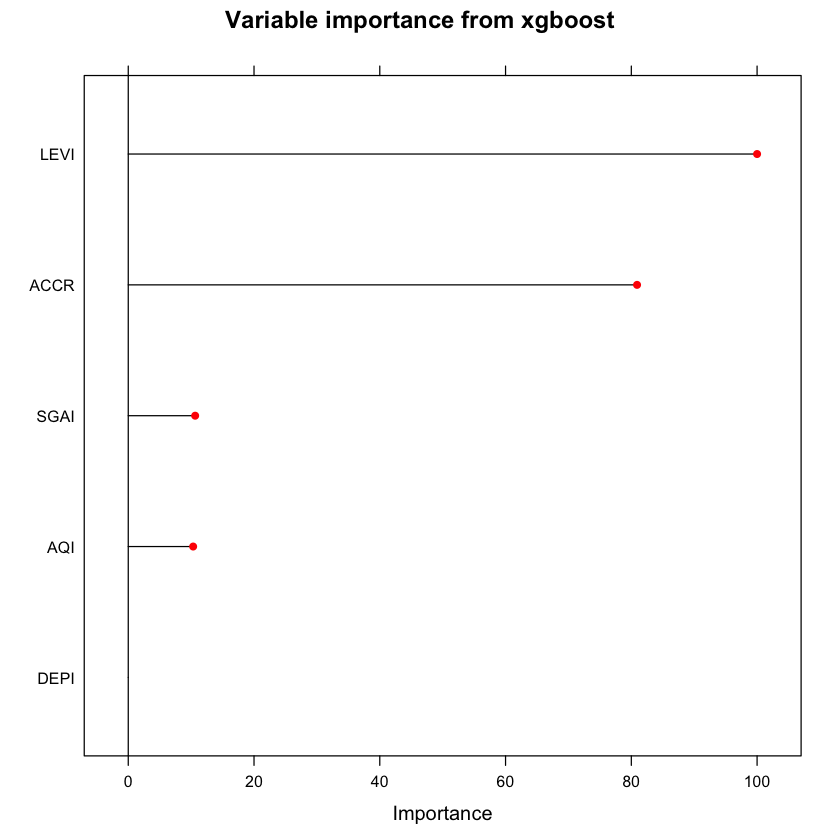

In [66]:
xg_model$bestTune
confusionMatrix.train(xg_model)

plot(varImp(xg_model), main = "Variable importance from xgboost", col = 2, lwd = 2)


Confusion Matrix for xgboost on test set


In [67]:
caretPredictedClass <- predict(xg_model, model_test_df[1:5], type = "raw")
confusionMatrix(caretPredictedClass,model_test_df$Manipulater)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  359  10
       Yes   1   1
                                          
               Accuracy : 0.9704          
                 95% CI : (0.9476, 0.9851)
    No Information Rate : 0.9704          
    P-Value [Acc > NIR] : 0.57928         
                                          
                  Kappa : 0.1461          
 Mcnemar's Test P-Value : 0.01586         
                                          
            Sensitivity : 0.99722         
            Specificity : 0.09091         
         Pos Pred Value : 0.97290         
         Neg Pred Value : 0.50000         
             Prevalence : 0.97035         
         Detection Rate : 0.96765         
   Detection Prevalence : 0.99461         
      Balanced Accuracy : 0.54407         
                                          
       'Positive' Class : No              
                                          


ROC plot for xgboost on test set


An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.8805556


Slot "alpha.values":
list()


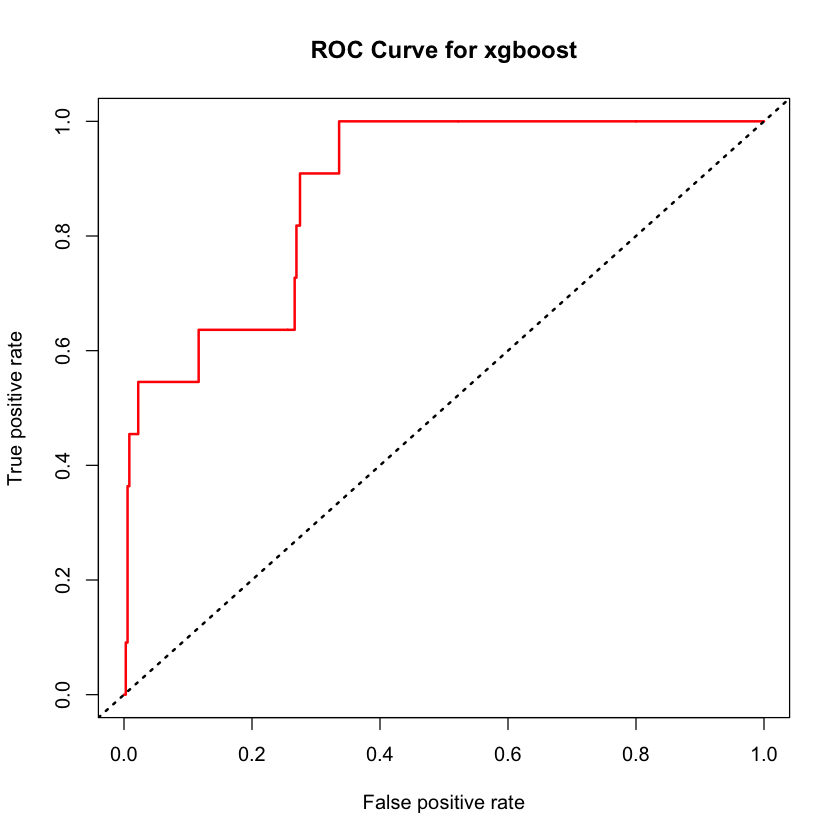

In [68]:
xg_pred <- predict(xg_model, model_test_df[1:5], type = "prob")[,2]
xg_prediction <- prediction(xg_pred,model_test_df$Manipulater)
xg_perf <- performance(xg_prediction, "tpr","fpr")

plot(xg_perf,main="ROC Curve for xgboost",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=3,col="black")

#AUC for the ROC plot
performance(xg_prediction, "auc")


### Boosting with xgboost (up sample)
The below code chunk sets some of the control parameters for adaboost


In [69]:
objControl <- trainControl(method='boot', number = 1,
                           returnResamp='final',
                           summaryFunction = twoClassSummary,
                           savePredictions = TRUE,
                           classProbs = TRUE, sampling = "up")

In [70]:
search_grid <- expand.grid(nrounds = c(70:150), max_depth = c(2:4),
                    eta = c(0.1,0.3,0.5),
                    gamma = c(0.03,0.09, 0.12),
                    colsample_bytree = c(5:10)/10,
                    min_child_weight = c(1:5),
                    subsample = c(0.5))


After setting the control paramters, the model is run


In [71]:
num_cores <- makeCluster(detectCores()-5)
registerDoParallel(num_cores)
tic("Xtreme Boosting with Up Sampling")

set.seed(4121)
xg_up_model <- train(model_train_df[,1:5], model_train_df[,6],
                  method='xgbTree',
                  trControl=objControl,
                  tuneGrid = search_grid,
                  metric = "ROC")
stopCluster(num_cores)
toc()

Xtreme Boosting with Up Sampling: 309.228 sec elapsed



Confusion Matrix for xgboost on train set


,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
28595,71,2,0.3,0.12,0.9,4,0.5


Bootstrapped (1 reps) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   No  Yes
       No  96.5  2.6
       Yes  1.0  0.0
                            
 Accuracy (average) : 0.9649


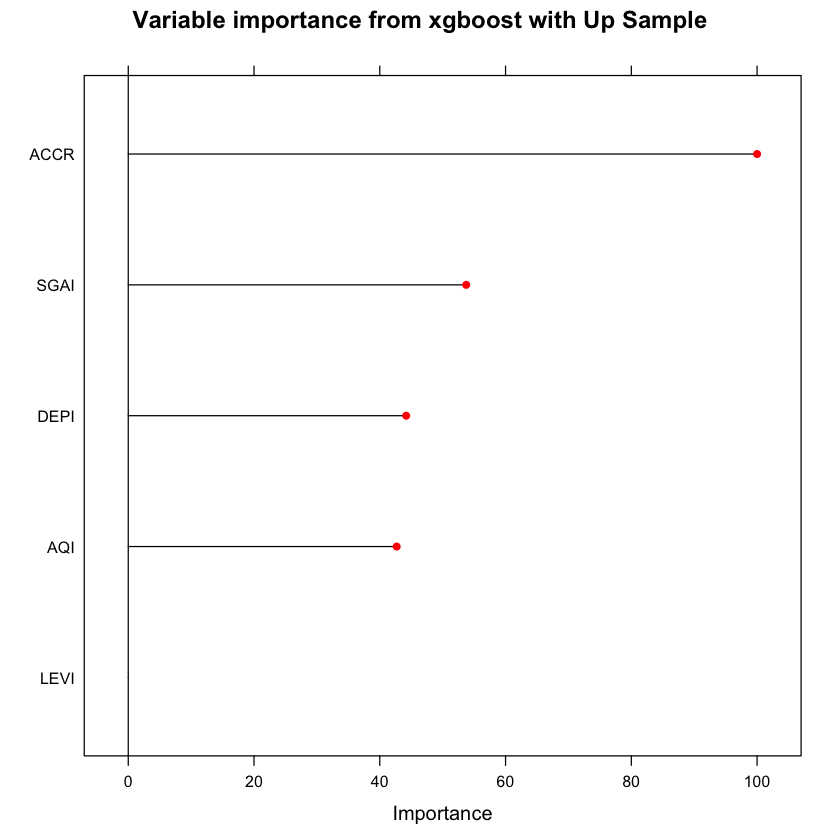

In [72]:
xg_up_model$bestTune
confusionMatrix.train(xg_up_model)

plot(varImp(xg_up_model), main = "Variable importance from xgboost with Up Sample", col = 2, lwd = 2)


Confusion Matrix for xgboost on test set


In [73]:
caretPredictedClass <- predict(xg_up_model, model_test_df[1:5], type = "raw")
confusionMatrix(caretPredictedClass,model_test_df$Manipulater)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  339   8
       Yes  21   3
                                         
               Accuracy : 0.9218         
                 95% CI : (0.8897, 0.947)
    No Information Rate : 0.9704         
    P-Value [Acc > NIR] : 1.00000        
                                         
                  Kappa : 0.1363         
 Mcnemar's Test P-Value : 0.02586        
                                         
            Sensitivity : 0.9417         
            Specificity : 0.2727         
         Pos Pred Value : 0.9769         
         Neg Pred Value : 0.1250         
             Prevalence : 0.9704         
         Detection Rate : 0.9137         
   Detection Prevalence : 0.9353         
      Balanced Accuracy : 0.6072         
                                         
       'Positive' Class : No             
                                         


ROC plot for xgboost on test set


An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.7833333


Slot "alpha.values":
list()


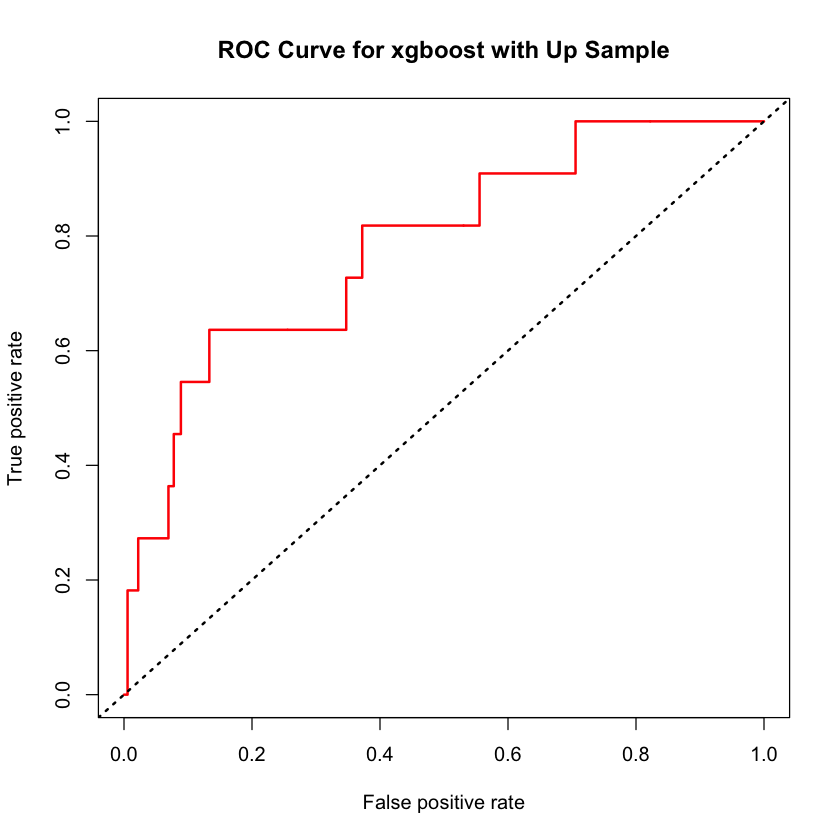

In [74]:
xg_pred <- predict(xg_up_model, model_test_df[1:5], type = "prob")[,2]
xg_prediction <- prediction(xg_pred,model_test_df$Manipulater)
xg_perf <- performance(xg_prediction, "tpr","fpr")

plot(xg_perf,main="ROC Curve for xgboost with Up Sample",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=3,col="black")

#AUC for the ROC plot
performance(xg_prediction, "auc")


### Boosting with xgboost (down sample)
The below code chunk sets some of the control parameters for adaboost


In [75]:
objControl <- trainControl(method='boot', number = 1,
                           returnResamp='final',
                           summaryFunction = twoClassSummary,
                           savePredictions = TRUE,
                           classProbs = TRUE, sampling = "down")

In [76]:
search_grid <- expand.grid(nrounds = c(70:150), max_depth = c(2:4),
                    eta = c(0.1,0.3,0.5),
                    gamma = c(0.03,0.09, 0.12),
                    colsample_bytree = c(5:10)/10,
                    min_child_weight = c(1:5),
                    subsample = c(0.5))


After setting the control paramters, the model is run


In [77]:
num_cores <- makeCluster(detectCores()-5)
registerDoParallel(num_cores)
tic("Xtreme Boosting with Down Sampling")
set.seed(4121)
xg_down_model <- train(model_train_df[,1:5], model_train_df[,6],
                  method='xgbTree',
                  trControl=objControl,
                  tuneGrid = search_grid,
                  metric = "ROC")
stopCluster(num_cores)
toc()

Xtreme Boosting with Down Sampling: 221.04 sec elapsed



Confusion Matrix for xgboost on train set


,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
36099,123,3,0.3,0.12,1,1,0.5


Bootstrapped (1 reps) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   No  Yes
       No  70.6  0.6
       Yes 26.8  1.9
                            
 Accuracy (average) : 0.7252


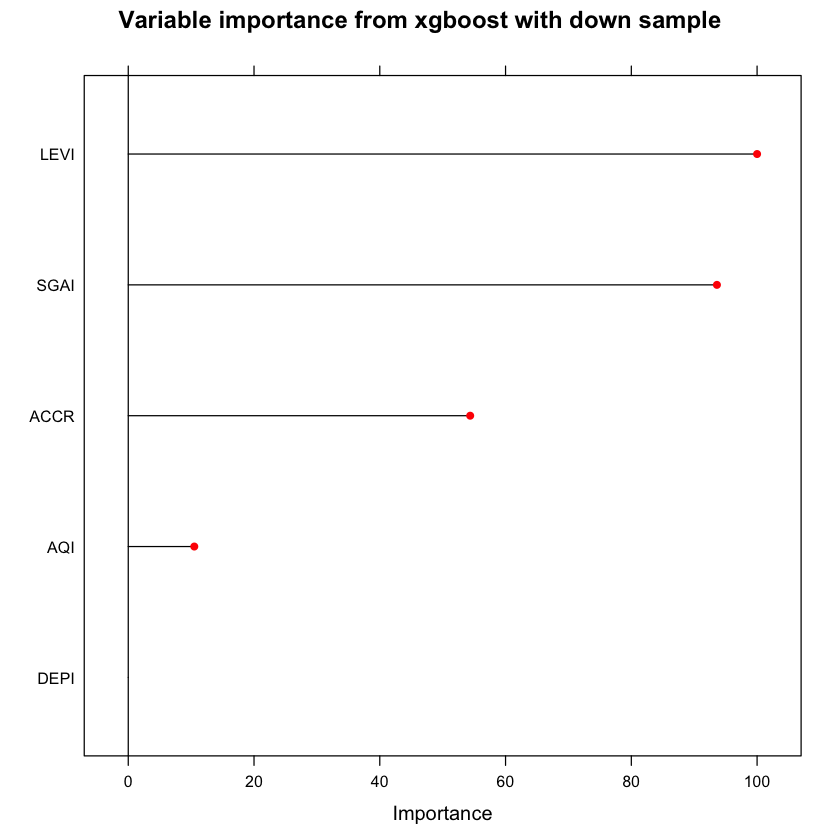

In [78]:
xg_down_model$bestTune
confusionMatrix.train(xg_down_model)

plot(varImp(xg_down_model), main = "Variable importance from xgboost with down sample", col = 2, lwd = 2)


Confusion Matrix for xgboost on test set


In [79]:
caretPredictedClass <- predict(xg_down_model, model_test_df[1:5], type = "raw")
confusionMatrix(caretPredictedClass,model_test_df$Manipulater)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  232   1
       Yes 128  10
                                          
               Accuracy : 0.6523          
                 95% CI : (0.6014, 0.7007)
    No Information Rate : 0.9704          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0839          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.64444         
            Specificity : 0.90909         
         Pos Pred Value : 0.99571         
         Neg Pred Value : 0.07246         
             Prevalence : 0.97035         
         Detection Rate : 0.62534         
   Detection Prevalence : 0.62803         
      Balanced Accuracy : 0.77677         
                                          
       'Positive' Class : No              
                                          


ROC plot for xgboost on test set


An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.8098485


Slot "alpha.values":
list()


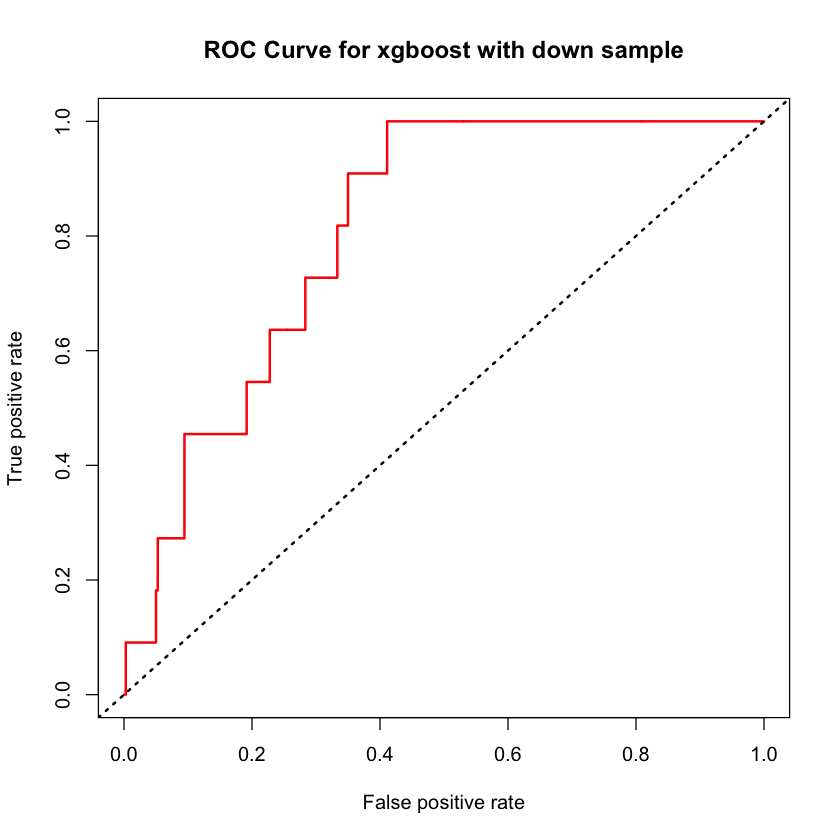

In [80]:
xg_pred <- predict(xg_down_model, model_test_df[1:5], type = "prob")[,2]
xg_prediction <- prediction(xg_pred,model_test_df$Manipulater)
xg_perf <- performance(xg_prediction, "tpr","fpr")

plot(xg_perf,main="ROC Curve for xgboost with down sample",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=3,col="black")

#AUC for the ROC plot
performance(xg_prediction, "auc")


### Boosting with xgboost (SMOTE)
The below code chunk sets some of the control parameters for adaboost


In [81]:
objControl <- trainControl(method='boot', number = 1,
                           returnResamp='final',
                           summaryFunction = twoClassSummary,
                           savePredictions = TRUE,
                           classProbs = TRUE, sampling = "smote")

In [82]:
search_grid <- expand.grid(nrounds = c(70:150), max_depth = c(2:4),
                    eta = c(0.1,0.3,0.5),
                    gamma = c(0.03,0.09, 0.12),
                    colsample_bytree = c(5:10)/10,
                    min_child_weight = c(1:5),
                    subsample = c(0.5))


After setting the control paramters, the model is run


In [83]:
num_cores <- makeCluster(detectCores()-5)
registerDoParallel(num_cores)
tic("Xtreme Boosting with SMOTE Sampling")
set.seed(4121)
xg_smote_model <- train(model_train_df[,1:5], model_train_df[,6],
                  method='xgbTree',
                  trControl=objControl,
                  tuneGrid = search_grid,
                  metric = "ROC")
stopCluster(num_cores)
toc()

Xtreme Boosting with SMOTE Sampling: 261.745 sec elapsed



Confusion Matrix for xgboost on train set


,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
45049,82,2,0.5,0.03,0.8,2,0.5


Bootstrapped (1 reps) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   No  Yes
       No  85.6  1.6
       Yes 11.8  1.0
                            
 Accuracy (average) : 0.8658


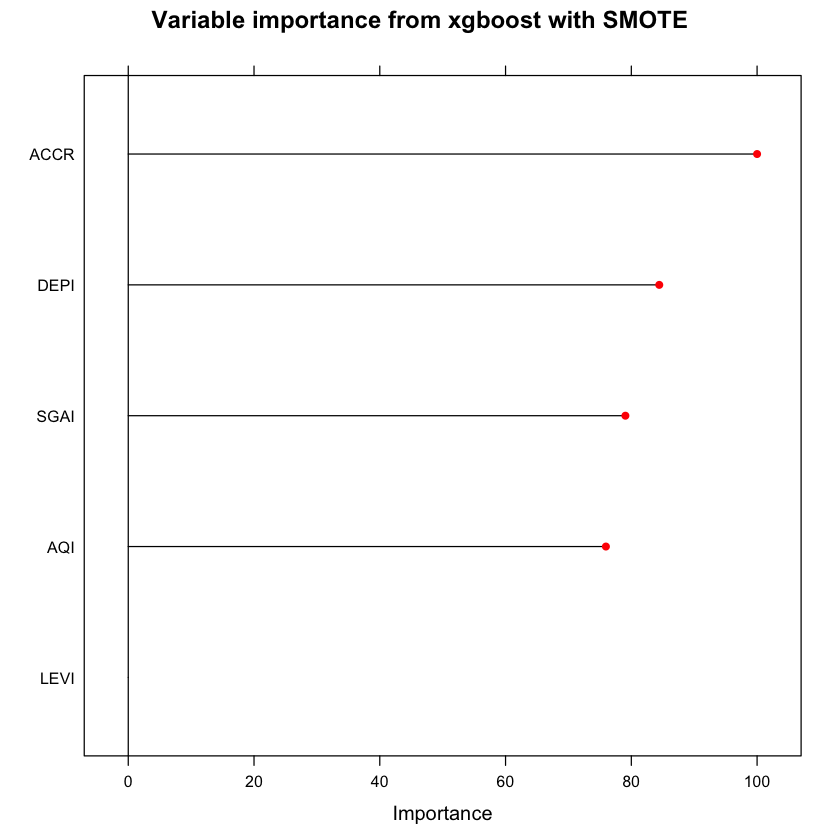

In [84]:
xg_smote_model$bestTune
confusionMatrix.train(xg_smote_model)

plot(varImp(xg_smote_model), main = "Variable importance from xgboost with SMOTE", col = 2, lwd = 2)


Confusion Matrix for xgboost on test set


In [85]:
caretPredictedClass <- predict(xg_smote_model, model_test_df[1:5], type = "raw")
confusionMatrix(caretPredictedClass,model_test_df$Manipulater)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  286   4
       Yes  74   7
                                          
               Accuracy : 0.7898          
                 95% CI : (0.7447, 0.8301)
    No Information Rate : 0.9704          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1055          
 Mcnemar's Test P-Value : 5.597e-15       
                                          
            Sensitivity : 0.79444         
            Specificity : 0.63636         
         Pos Pred Value : 0.98621         
         Neg Pred Value : 0.08642         
             Prevalence : 0.97035         
         Detection Rate : 0.77089         
   Detection Prevalence : 0.78167         
      Balanced Accuracy : 0.71540         
                                          
       'Positive' Class : No              
                                          


ROC plot for xgboost on test set


An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.8194444


Slot "alpha.values":
list()


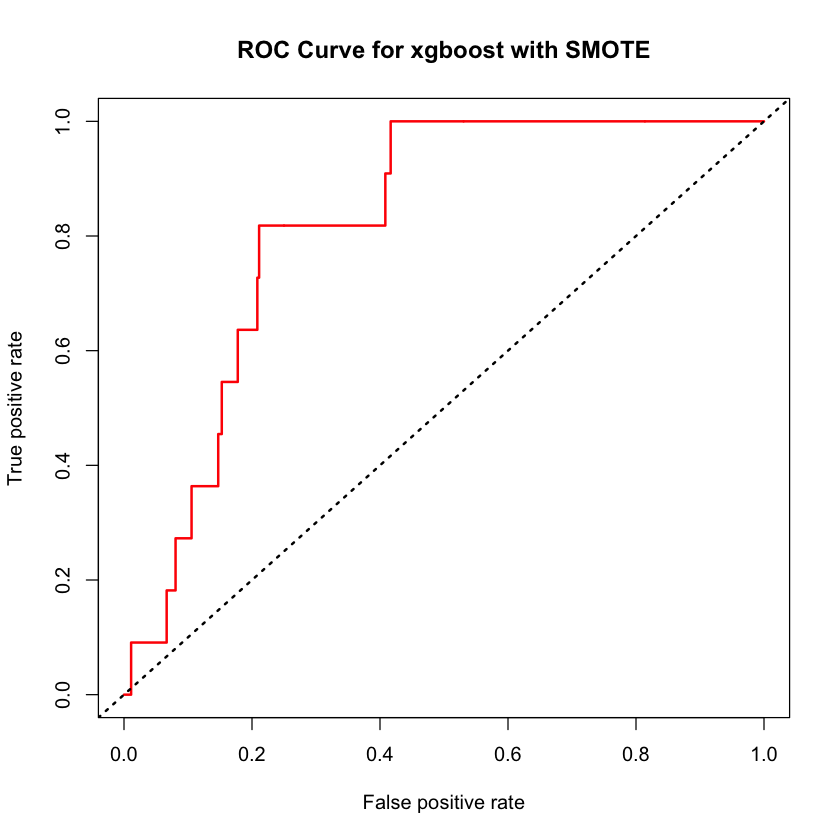

In [86]:
xg_pred <- predict(xg_smote_model, model_test_df[1:5], type = "prob")[,2]
xg_prediction <- prediction(xg_pred,model_test_df$Manipulater)
xg_perf <- performance(xg_prediction, "tpr","fpr")

plot(xg_perf,main="ROC Curve for xgboost with SMOTE",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=3,col="black")

#AUC for the ROC plot
performance(xg_prediction, "auc")

In [87]:
toc()

Total Time for Bagging and Boosting: 1577.322 sec elapsed



## Neural Network

### Neural network implementation to find the manipulaters
The below code chunk sets some of the control parameters


In [88]:
objControl <- trainControl(method='boot', number = 1,
                           returnResamp='none',
                           summaryFunction = twoClassSummary,
                           savePredictions = TRUE,
                           classProbs = TRUE, allowParallel=FALSE)


Using search grid to fine tune the neural network. **Size** fine tunes number of hidden units to tune and **decay** fine tunes weight decay


In [89]:
search_grid <- expand.grid(.decay = c(0.5, 0.1, 0.05), .size = c(2, 3, 4,5,6,7))


After setting the control paramters, the model is run. If we use **linout=TRUE** in **train()** the neural network builds a regression model. **linout=FALSE** will make **nnet** use a sigmodial function and all the predictions will be constrained between **[0,1]**


In [90]:
set.seed(4121)

nn_model <- train(model_train_df[,1:5], model_train_df[,6],
                  method='nnet',
                  trControl=objControl,
                  metric = "ROC",
                  maxit = 1000,
                  tuneGrid = search_grid,
                  trace = FALSE,
                  linout = FALSE)


Confusion Matrix for Neural Network  on train set


Neural Network 

868 samples
  5 predictor
  2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Bootstrapped (1 reps) 
Summary of sample sizes: 868 
Resampling results across tuning parameters:

  decay  size  ROC        Sens       Spec
  0.05   2     0.6418033  0.9967213  0   
  0.05   3     0.6221311  0.9967213  0   
  0.05   4     0.5393443  0.9967213  0   
  0.05   5     0.6524590  0.9967213  0   
  0.05   6     0.5799180  0.9967213  0   
  0.05   7     0.4901639  0.9967213  0   
  0.10   2     0.5676230  0.9967213  0   
  0.10   3     0.5991803  0.9967213  0   
  0.10   4     0.6245902  0.9967213  0   
  0.10   5     0.6131148  0.9934426  0   
  0.10   6     0.5979508  0.9934426  0   
  0.10   7     0.5778689  0.9967213  0   
  0.50   2     0.3692623  1.0000000  0   
  0.50   3     0.3905738  0.9967213  0   
  0.50   4     0.3942623  0.9967213  0   
  0.50   5     0.3840164  0.9967213  0   
  0.50   6     0.3926230  0.9967213  0   
  0.50   7     0.3770492  0.9967213  0   

RO

Bootstrapped (1 reps) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   No  Yes
       No  97.1  2.6
       Yes  0.3  0.0
                            
 Accuracy (average) : 0.9712


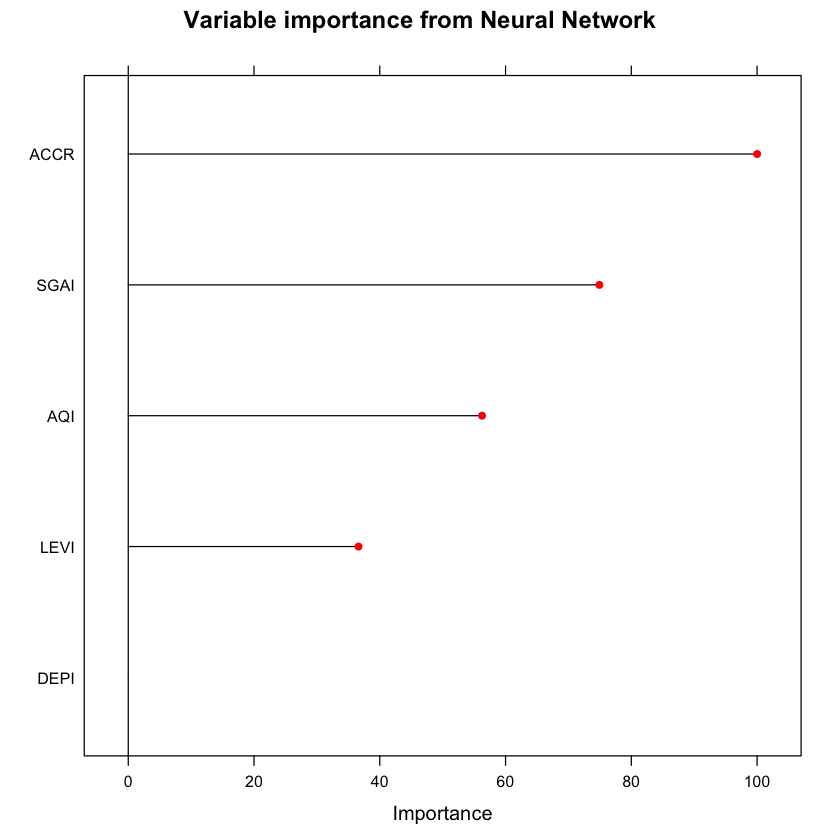

In [91]:
#nn_model$finalModel #nn_model$results
print(nn_model)
confusionMatrix.train(nn_model)
plot(varImp(nn_model), main = "Variable importance from Neural Network", col = 2, lwd = 2)


Confusion Matrix for Neural Network  on test set


In [92]:
caretPredictedClass <- predict(nn_model, model_test_df, type = "raw")
confusionMatrix(caretPredictedClass,model_test_df$Manipulater)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  359  11
       Yes   1   0
                                          
               Accuracy : 0.9677          
                 95% CI : (0.9442, 0.9832)
    No Information Rate : 0.9704          
    P-Value [Acc > NIR] : 0.690364        
                                          
                  Kappa : -0.005          
 Mcnemar's Test P-Value : 0.009375        
                                          
            Sensitivity : 0.9972          
            Specificity : 0.0000          
         Pos Pred Value : 0.9703          
         Neg Pred Value : 0.0000          
             Prevalence : 0.9704          
         Detection Rate : 0.9677          
   Detection Prevalence : 0.9973          
      Balanced Accuracy : 0.4986          
                                          
       'Positive' Class : No              
                                          


ROC plot for Neural Network on test set


An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.830303


Slot "alpha.values":
list()


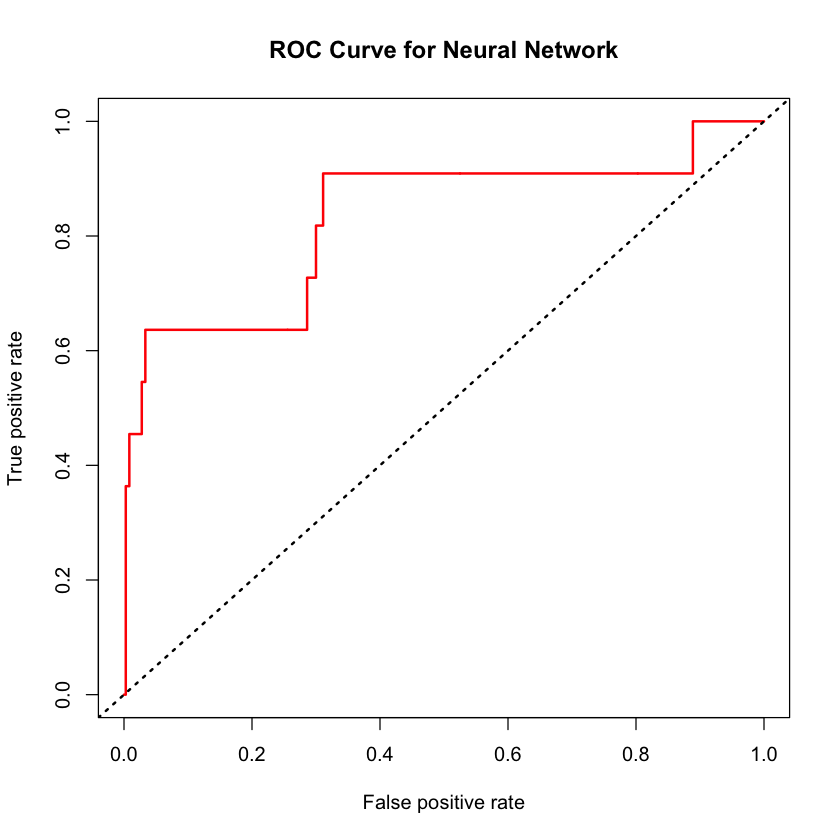

In [93]:
nn_pred <- predict(nn_model, model_test_df, type = "prob")[,2]
nn_prediction <- prediction(nn_pred,model_test_df$Manipulater)
nn_perf <- performance(nn_prediction, "tpr","fpr")

plot(nn_perf,main="ROC Curve for Neural Network",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=3,col="black")

#AUC for the ROC plot
performance(nn_prediction, "auc")


## Logistic Regression
The variables DSRI and GMI causes fitted probability to be numerically 0 or 1. Using less number of variables in the logistic regression.


In [94]:
lg_model_df <- as.data.frame(filter_data[,c(#"DSRI",
                                          #"GMI",
                                          "AQI",
                                          "SGI",
                                          "DEPI",
                                          "SGAI",
                                          "ACCR",
                                          "LEVI",
                                          "Manipulater"
)])
lg_train_df <- as.data.frame(train_df[,c(#"DSRI",
                                          #"GMI",
                                          "AQI",
                                          "SGI",
                                          "DEPI",
                                          "SGAI",
                                          "ACCR",
                                          "LEVI",
                                          "Manipulater"
)])
lg_test_df <- as.data.frame(test_df[,c(#"DSRI",
                                          #"GMI",
                                          "AQI",
                                          "SGI",
                                          "DEPI",
                                          "SGAI",
                                          "ACCR",
                                          "LEVI",
                                          "Manipulater"
)])


The below code chunk sets some of the control parameters


In [95]:
objControl <- trainControl(method='boot', number=1,
                           returnResamp='none',
                           summaryFunction = twoClassSummary,
                           savePredictions = TRUE,
                           classProbs = TRUE,allowParallel=FALSE)


After setting the control paramters, the model is run


In [96]:
set.seed(4121)
lg_model <- train(lg_train_df[,1:6], lg_train_df[,7],
                     method='glmStepAIC',
                     trControl=objControl,
                     metric = "ROC")

Start:  AIC=196.08
.outcome ~ AQI + SGI + DEPI + SGAI + ACCR + LEVI

       Df Deviance    AIC
- LEVI  1   183.09 195.09
<none>      182.08 196.08
- DEPI  1   184.44 196.44
- AQI   1   186.75 198.75
- SGI   1   189.02 201.02
- SGAI  1   215.58 227.58
- ACCR  1   233.01 245.01

Step:  AIC=195.09
.outcome ~ AQI + SGI + DEPI + SGAI + ACCR

       Df Deviance    AIC
<none>      183.09 195.09
- DEPI  1   185.39 195.39
- AQI   1   187.75 197.75
- SGI   1   189.69 199.69
- SGAI  1   216.46 226.46
- ACCR  1   233.53 243.53
Start:  AIC=216.72
.outcome ~ AQI + SGI + DEPI + SGAI + ACCR + LEVI

       Df Deviance    AIC
- DEPI  1   203.35 215.35
<none>      202.72 216.72
- LEVI  1   206.04 218.04
- SGI   1   209.63 221.63
- AQI   1   214.90 226.90
- SGAI  1   215.20 227.20
- ACCR  1   217.84 229.84

Step:  AIC=215.35
.outcome ~ AQI + SGI + SGAI + ACCR + LEVI

       Df Deviance    AIC
<none>      203.35 215.35
- LEVI  1   206.72 216.72
- SGI   1   210.29 220.29
- AQI   1   217.09 227.09
- SGAI  1 


Confusion Matrix for logistic regression on train set


Generalized Linear Model with Stepwise Feature Selection 

868 samples
  6 predictor
  2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Bootstrapped (1 reps) 
Summary of sample sizes: 868 
Resampling results:

  ROC        Sens       Spec
  0.6983607  0.9934426  0.25



Bootstrapped (1 reps) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   No  Yes
       No  96.8  1.9
       Yes  0.6  0.6
                            
 Accuracy (average) : 0.9744


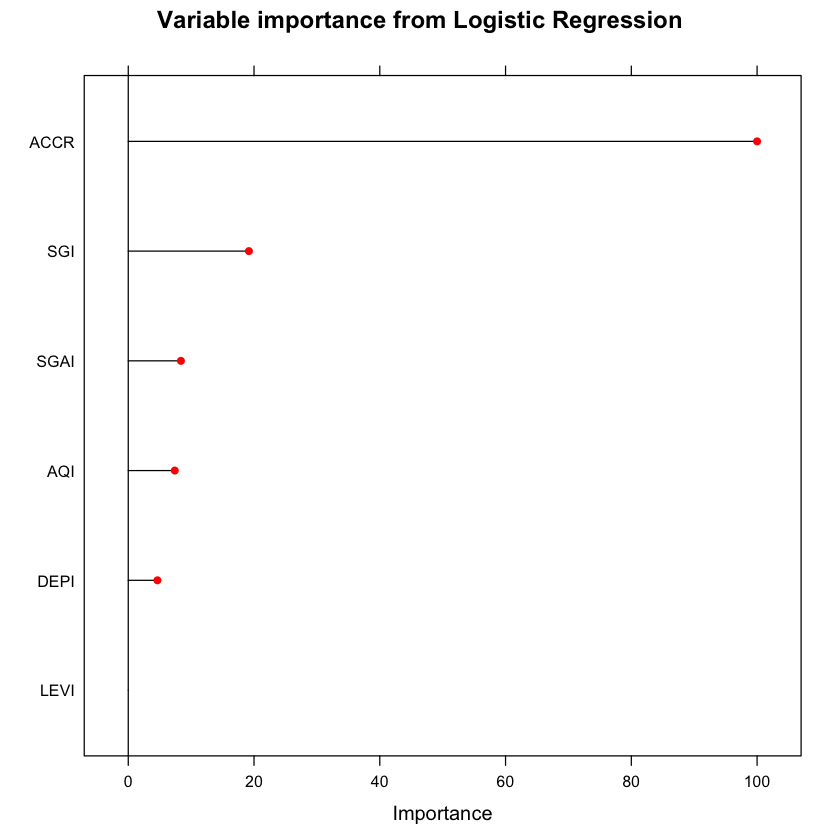

In [97]:
print(lg_model)
confusionMatrix.train(lg_model)
plot(varImp(lg_model), main = "Variable importance from Logistic Regression", col = 2, lwd = 2)


Confusion Matrix for logistic regression on test set


In [98]:
caretPredictedClass <- predict(lg_model, lg_test_df, type = "raw")
confusionMatrix(caretPredictedClass,lg_test_df$Manipulater)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  360   9
       Yes   0   2
                                          
               Accuracy : 0.9757          
                 95% CI : (0.9545, 0.9888)
    No Information Rate : 0.9704          
    P-Value [Acc > NIR] : 0.337237        
                                          
                  Kappa : 0.3013          
 Mcnemar's Test P-Value : 0.007661        
                                          
            Sensitivity : 1.0000          
            Specificity : 0.1818          
         Pos Pred Value : 0.9756          
         Neg Pred Value : 1.0000          
             Prevalence : 0.9704          
         Detection Rate : 0.9704          
   Detection Prevalence : 0.9946          
      Balanced Accuracy : 0.5909          
                                          
       'Positive' Class : No              
                                          


ROC plot for logistic regression


An object of class "performance"
Slot "x.name":
[1] "None"

Slot "y.name":
[1] "Area under the ROC curve"

Slot "alpha.name":
[1] "none"

Slot "x.values":
list()

Slot "y.values":
[[1]]
[1] 0.935101


Slot "alpha.values":
list()


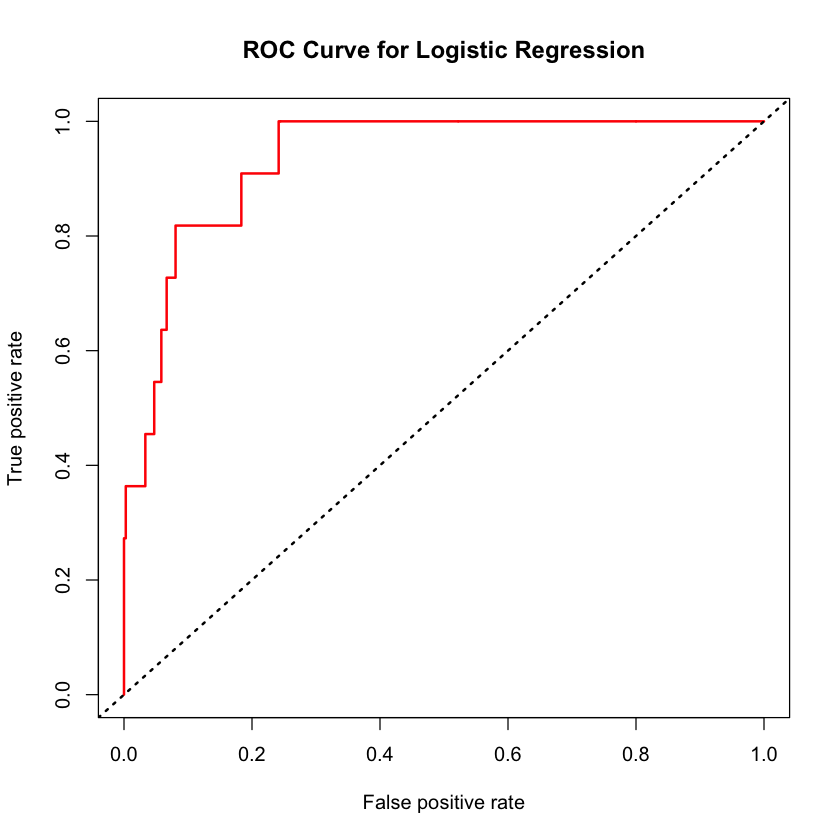

In [99]:
lg_pred <- predict(lg_model, lg_test_df, type = "prob")[,2]
lg_prediction <- prediction(lg_pred,lg_test_df$Manipulater)
lg_perf <- performance(lg_prediction, "tpr","fpr")

plot(lg_perf,main="ROC Curve for Logistic Regression",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=3,col="black")

#AUC for the ROC plot
performance(lg_prediction, "auc")


End of document

***
